
# **Description**
* This colab includes codings required for questions 1-21.
* To avoid messy code and improve the organization, codes for the rest of questions (22-27) are in the following link: https://colab.research.google.com/drive/1CWlbIOJabOWeNYUa4OD7Jf_-JUKk4zn2?usp=sharing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
test = '/content/drive/MyDrive/Data Mining Class (Master)/HW3/Dataset/test.csv'
train = '/content/drive/MyDrive/Data Mining Class (Master)/HW3/Dataset/train.csv'

train_df = pd.read_csv(train)
test_df = pd.read_csv(test)


In [ ]:
train_df.head(2)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2


In [ ]:
categorical_features = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']

**Preprocess**

In [ ]:
#delete a column if more than 50% of instances have null value
to_be_deleted_cols = train_df.columns[train_df.isna().sum()/len(train_df) > 0.50]
train_df.drop(columns=to_be_deleted_cols, inplace = True)
print(train_df.shape)

# Numerical Feature: If an instance has Nan value for a column, replace it with average value of that feature 
features_mean_val = train_df._get_numeric_data().mean()
train_df.fillna(features_mean_val, inplace = True)

# Categorical Feature: If an instance has Nan value for a column, replace it with the value that is the most frequent
for col in train_df.columns:
  if train_df[col].dtype == 'object' or train_df[col].dtype == 'bool' or col in categorical_features:
    highest_count = train_df[col].value_counts().index[0]
    print('Column: {}, Most frequent value: {}'.format(col, highest_count))
    train_df[col].fillna(highest_count, inplace = True)
  


# Find categorical features that have too many (50+) possible values and remove them
col_w_too_vals = []
for col in train_df.columns:
    if train_df[col].dtype == 'object' or train_df[col].dtype == 'bool' or col in categorical_features:
      if train_df[col].nunique() >=50:
        col_w_too_vals.append(col)
        print('cols : {} , # of unique values : {}'.format(col, train_df[col].nunique()))

train_df = train_df.drop(columns=col_w_too_vals)

# Keep a version of data before normalization for question 6
train_df_org =train_df.copy(deep = True)

# normalize
for cols in train_df.columns:
  if (train_df[cols].dtype == 'int64' or train_df[cols].dtype == 'float64') and (train_df[cols].dtype!='bool' and train_df[cols].dtype!='object' and not (cols in categorical_features)) :
    print(cols)
    if cols != 'price_range':
      train_df[cols] = ((train_df[cols] - train_df[cols].mean())/train_df[cols].std())

train_df.shape

(2000, 21)
Column: blue, Most frequent value: 0
Column: dual_sim, Most frequent value: 1
Column: four_g, Most frequent value: 1
Column: three_g, Most frequent value: 1
Column: touch_screen, Most frequent value: 1
Column: wifi, Most frequent value: 1
battery_power
clock_speed
fc
int_memory
m_dep
mobile_wt
n_cores
pc
px_height
px_width
ram
sc_h
sc_w
talk_time
price_range


(2000, 21)

In [ ]:
from sklearn.utils import shuffle

features = list(train_df.columns)[:-1]

X = train_df[features]
y = train_df["price_range"]
labels = np.unique(y)
print(len(X), len(labels))

2000 4


In [ ]:
X.head(2)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,-0.902372,0,0.830572,0,-0.762304,0,-1.380298,0.340654,1.348911,-1.101696,-1.305424,-1.408596,-1.146497,0.391605,-0.784787,0.283032,1.462128,0,0,1
1,-0.495015,1,-1.252751,1,-0.992642,1,1.154735,0.687376,-0.120029,-0.664602,-0.645827,0.585631,1.704039,0.467200,1.113987,-0.635158,-0.734084,1,1,0


**SVM**

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC
from copy import deepcopy

# Args
# multiclass_decision={'ovo' -- one vs one, 'ovr' -- one vs rest}, default = 'ovr'
# kernel = {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default = 'rbf'
# gamma: Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’ = {‘scale’, ‘auto’}, default = 'scale'
def svm_w_kernel(X, y, kernel='rbf', gamma = 'scale', C = 1,
                 multiclass_decision='ovr', train_size=.8, print_f1 = True):  

  train_size = int(train_size * len(X))

  X_train = deepcopy(X[:train_size])
  y_train = deepcopy(y[:train_size])

  X_test = deepcopy(X[train_size:])
  y_test = deepcopy(y[train_size:])

  
  clf = SVC(kernel = kernel, gamma = gamma, C = C,
            decision_function_shape = multiclass_decision)
  clf.fit(X_train, y_train)

  y_pred = clf.predict(X_test)
  p, r, f, s = precision_recall_fscore_support(y_test, y_pred, average=None)

  if kernel in ('poly', 'rbf', 'sigmoid'):
    print('SVM results for kernel {} and Kernel coeff {}--'.format(kernel, gamma), 'accuracy: ', clf.score(X_test, y_test))
    if print_f1:
      print('Precision: ', round(np.mean(p), 4), p)
      print('Recall: ', round(np.mean(r),4), r)
      print('Fscore: ', round(np.mean(f),4), f)
  else:
    print('SVM results for kernel {}--'.format(kernel), 'accuracy: ', clf.score(X_test, y_test))
    if print_f1:
      print('Precision: ', round(np.mean(p), 4), p)
      print('Recall: ', round(np.mean(r),4), r)
      print('Fscore: ', round(np.mean(f),4), f)


In [ ]:
# SVM for 4 classes: One vs One
for kernel in ('linear','poly', 'rbf', 'sigmoid'):
  if kernel in ('poly', 'rbf', 'sigmoid'):
    for gamma in ('auto', 'scale'):
      svm_w_kernel(X[features].values, y.values, kernel, gamma, multiclass_decision = 'ovo',train_size = 0.8)
      print('=========================')
  else:
    svm_w_kernel(X[features].values, y.values, kernel, multiclass_decision = 'ovo', train_size=0.8)
    print('=========================')

SVM results for kernel linear-- accuracy:  0.9725
Precision:  0.9724 [0.99038462 0.95192308 0.9673913  0.98      ]
Recall:  0.9719 [0.99038462 0.97058824 0.93684211 0.98989899]
Fscore:  0.9721 [0.99038462 0.96116505 0.95187166 0.98492462]
SVM results for kernel poly and Kernel coeff auto-- accuracy:  0.8025
Precision:  0.8272 [0.975      0.68852459 0.69298246 0.95238095]
Recall:  0.8033 [0.75       0.82352941 0.83157895 0.80808081]
Fscore:  0.807 [0.84782609 0.75       0.75598086 0.87431694]
SVM results for kernel poly and Kernel coeff scale-- accuracy:  0.8175
Precision:  0.8331 [0.94318182 0.72566372 0.71052632 0.95294118]
Recall:  0.8182 [0.79807692 0.80392157 0.85263158 0.81818182]
Fscore:  0.8207 [0.86458333 0.7627907  0.77511962 0.88043478]
SVM results for kernel rbf and Kernel coeff auto-- accuracy:  0.895
Precision:  0.8975 [0.96875    0.81981982 0.85263158 0.94897959]
Recall:  0.8946 [0.89423077 0.89215686 0.85263158 0.93939394]
Fscore:  0.8953 [0.93       0.85446009 0.8526315

In [ ]:
# SVM for 4 classes: One vs Rest
for kernel in ('linear', 'poly', 'rbf', 'sigmoid'):
  if kernel in ('poly', 'rbf', 'sigmoid'):
    for gamma in ('auto', 'scale'):
      svm_w_kernel(X[features].values, y.values, kernel, gamma, multiclass_decision ='ovr', train_size=0.8)
      print('=========================')
  else:
    svm_w_kernel(X[features].values, y.values, kernel, multiclass_decision ='ovr', train_size= 0.8)
    print('=========================')

SVM results for kernel linear-- accuracy:  0.9725
Precision:  0.9724 [0.99038462 0.95192308 0.9673913  0.98      ]
Recall:  0.9719 [0.99038462 0.97058824 0.93684211 0.98989899]
Fscore:  0.9721 [0.99038462 0.96116505 0.95187166 0.98492462]
SVM results for kernel poly and Kernel coeff auto-- accuracy:  0.8025
Precision:  0.8272 [0.975      0.68852459 0.69298246 0.95238095]
Recall:  0.8033 [0.75       0.82352941 0.83157895 0.80808081]
Fscore:  0.807 [0.84782609 0.75       0.75598086 0.87431694]
SVM results for kernel poly and Kernel coeff scale-- accuracy:  0.8175
Precision:  0.8331 [0.94318182 0.72566372 0.71052632 0.95294118]
Recall:  0.8182 [0.79807692 0.80392157 0.85263158 0.81818182]
Fscore:  0.8207 [0.86458333 0.7627907  0.77511962 0.88043478]
SVM results for kernel rbf and Kernel coeff auto-- accuracy:  0.895
Precision:  0.8975 [0.96875    0.81981982 0.85263158 0.94897959]
Recall:  0.8946 [0.89423077 0.89215686 0.85263158 0.93939394]
Fscore:  0.8953 [0.93       0.85446009 0.8526315

**Sofrt margin vs Hard margin**

# The lower the C is, the lower regularization is, and the less punishment we have for missclassification => Softer margin

*   Softer margin: Lower C
*   Hard margin: Larger C--> 1e10



In [ ]:
# SVM for 4 classes: One vs Rest
for kernel in ('linear', 'poly', 'rbf', 'sigmoid'):
  print('Soft Margin, C = 0.0001')
  svm_w_kernel(X[features].values, y.values, kernel, C = 0.0001, multiclass_decision ='ovr', train_size=0.8)
  
  print('Soft Margin, C = 0.001')
  svm_w_kernel(X[features].values, y.values, kernel, C = 0.001, multiclass_decision ='ovr', train_size=0.8)

  print('Soft Margin, C = 0.1')
  svm_w_kernel(X[features].values, y.values, kernel, C = 0.1, multiclass_decision = 'ovr', train_size=0.8)

  print('Soft Margin, C = 1')
  svm_w_kernel(X[features].values, y.values, kernel, C = 1, multiclass_decision = 'ovr', train_size=0.8)
  
  print('Soft Margin, C = 10')
  svm_w_kernel(X[features].values, y.values, kernel, C = 10, multiclass_decision ='ovr', train_size=0.8)

  print('Soft Margin, C = 100')
  svm_w_kernel(X[features].values, y.values, kernel, C = 100, multiclass_decision ='ovr', train_size=0.8)
  
  print('Hard Margin')
  svm_w_kernel(X[features].values, y.values, kernel, C = 1e5,multiclass_decision= 'ovr', train_size=0.8)
  print('=========================')


Soft Margin, C = 0.0001
SVM results for kernel linear-- accuracy:  0.2375
Precision:  0.0594 [0.     0.     0.2375 0.    ]
Recall:  0.25 [0. 0. 1. 0.]
Fscore:  0.096 [0.         0.         0.38383838 0.        ]
Soft Margin, C = 0.001


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM results for kernel linear-- accuracy:  0.51
Precision:  0.5964 [0.73684211 0.24444444 0.40434783 1.        ]
Recall:  0.5157 [0.67307692 0.10784314 0.97894737 0.3030303 ]
Fscore:  0.4727 [0.70351759 0.14965986 0.57230769 0.46511628]
Soft Margin, C = 0.1
SVM results for kernel linear-- accuracy:  0.945
Precision:  0.9461 [0.98019802 0.88990826 0.93478261 0.97959184]
Recall:  0.9445 [0.95192308 0.95098039 0.90526316 0.96969697]
Fscore:  0.9449 [0.96585366 0.91943128 0.9197861  0.97461929]
Soft Margin, C = 1
SVM results for kernel linear-- accuracy:  0.9725
Precision:  0.9724 [0.99038462 0.95192308 0.9673913  0.98      ]
Recall:  0.9719 [0.99038462 0.97058824 0.93684211 0.98989899]
Fscore:  0.9721 [0.99038462 0.96116505 0.95187166 0.98492462]
Soft Margin, C = 10
SVM results for kernel linear-- accuracy:  0.97
Precision:  0.9701 [1.         0.94339623 0.94736842 0.98969072]
Recall:  0.9696 [0.98076923 0.98039216 0.94736842 0.96969697]
Fscore:  0.9697 [0.99029126 0.96153846 0.94736842 0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM results for kernel poly and Kernel coeff scale-- accuracy:  0.2375
Precision:  0.0594 [0.     0.     0.2375 0.    ]
Recall:  0.25 [0. 0. 1. 0.]
Fscore:  0.096 [0.         0.         0.38383838 0.        ]
Soft Margin, C = 0.1
SVM results for kernel poly and Kernel coeff scale-- accuracy:  0.5725
Precision:  0.687 [0.94285714 0.38983051 0.41517857 1.        ]
Recall:  0.5785 [0.63461538 0.2254902  0.97894737 0.47474747]
Fscore:  0.5678 [0.75862069 0.28571429 0.5830721  0.64383562]
Soft Margin, C = 1
SVM results for kernel poly and Kernel coeff scale-- accuracy:  0.8175
Precision:  0.8331 [0.94318182 0.72566372 0.71052632 0.95294118]
Recall:  0.8182 [0.79807692 0.80392157 0.85263158 0.81818182]
Fscore:  0.8207 [0.86458333 0.7627907  0.77511962 0.88043478]
Soft Margin, C = 10
SVM results for kernel poly and Kernel coeff scale-- accuracy:  0.8075
Precision:  0.811 [0.90625    0.71171171 0.72916667 0.89690722]
Recall:  0.8067 [0.83653846 0.7745098  0.73684211 0.87878788]
Fscore:  0.8081

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.2375
Precision:  0.0594 [0.     0.     0.2375 0.    ]
Recall:  0.25 [0. 0. 1. 0.]
Fscore:  0.096 [0.         0.         0.38383838 0.        ]
Soft Margin, C = 0.001


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.2375
Precision:  0.0594 [0.     0.     0.2375 0.    ]
Recall:  0.25 [0. 0. 1. 0.]
Fscore:  0.096 [0.         0.         0.38383838 0.        ]
Soft Margin, C = 0.1
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.74
Precision:  0.7741 [0.93975904 0.60714286 0.58730159 0.96202532]
Recall:  0.7408 [0.75       0.66666667 0.77894737 0.76767677]
Fscore:  0.7483 [0.8342246  0.63551402 0.66968326 0.85393258]
Soft Margin, C = 1
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8875
Precision:  0.891 [0.96808511 0.81081081 0.83673469 0.94845361]
Recall:  0.8875 [0.875      0.88235294 0.86315789 0.92929293]
Fscore:  0.8882 [0.91919192 0.84507042 0.84974093 0.93877551]
Soft Margin, C = 10
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.885
Precision:  0.885 [0.93069307 0.82857143 0.875      0.90566038]
Recall:  0.8843 [0.90384615 0.85294118 0.81052632 0.96969697]
Fscore:  0.8839 [0.917

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM results for kernel sigmoid and Kernel coeff scale-- accuracy:  0.2375
Precision:  0.0594 [0.     0.     0.2375 0.    ]
Recall:  0.25 [0. 0. 1. 0.]
Fscore:  0.096 [0.         0.         0.38383838 0.        ]
Soft Margin, C = 0.001


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM results for kernel sigmoid and Kernel coeff scale-- accuracy:  0.2375
Precision:  0.0594 [0.     0.     0.2375 0.    ]
Recall:  0.25 [0. 0. 1. 0.]
Fscore:  0.096 [0.         0.         0.38383838 0.        ]
Soft Margin, C = 0.1
SVM results for kernel sigmoid and Kernel coeff scale-- accuracy:  0.8725
Precision:  0.883 [0.96907216 0.79130435 0.77142857 1.        ]
Recall:  0.8718 [0.90384615 0.89215686 0.85263158 0.83838384]
Fscore:  0.874 [0.93532338 0.83870968 0.81       0.91208791]
Soft Margin, C = 1
SVM results for kernel sigmoid and Kernel coeff scale-- accuracy:  0.905
Precision:  0.906 [0.96116505 0.84684685 0.85869565 0.95744681]
Recall:  0.9035 [0.95192308 0.92156863 0.83157895 0.90909091]
Fscore:  0.9042 [0.95652174 0.88262911 0.84491979 0.93264249]
Soft Margin, C = 10
SVM results for kernel sigmoid and Kernel coeff scale-- accuracy:  0.845
Precision:  0.8458 [0.9047619  0.78899083 0.78723404 0.90217391]
Recall:  0.8435 [0.91346154 0.84313725 0.77894737 0.83838384]
Fscore

# **Feature Engineering and SVM**

In [ ]:
X.head(2)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,-0.902372,0,0.830572,0,-0.762304,0,-1.380298,0.340654,1.348911,-1.101696,-1.305424,-1.408596,-1.146497,0.391605,-0.784787,0.283032,1.462128,0,0,1
1,-0.495015,1,-1.252751,1,-0.992642,1,1.154735,0.687376,-0.120029,-0.664602,-0.645827,0.585631,1.704039,0.467200,1.113987,-0.635158,-0.734084,1,1,0


In [ ]:
features

['battery_power',
 'blue',
 'clock_speed',
 'dual_sim',
 'fc',
 'four_g',
 'int_memory',
 'm_dep',
 'mobile_wt',
 'n_cores',
 'pc',
 'px_height',
 'px_width',
 'ram',
 'sc_h',
 'sc_w',
 'talk_time',
 'three_g',
 'touch_screen',
 'wifi']

**binning**

In [ ]:
X['battery_power'].min(), X['battery_power'].max(), X['battery_power'].mean()

(-1.678397685369917, 1.728379683602883, 2.0849988402460439e-16)

In [ ]:
X['batter_power_5_bins'], bins_5 = pd.cut(X['battery_power'], 5, retbins = True, labels=range(5))#labels = range(10)
X['batter_power_10_bins'], bins_10 = pd.cut(X['battery_power'], 10, retbins = True, labels = range(10))#labels = range(10)


In [ ]:
bins_5

array([-1.68180446, -0.99704221, -0.31568674,  0.36566874,  1.04702421,
        1.72837968])

In [ ]:
X['batter_power_unequal_5_bins'], bins_5_unequal = pd.cut(X['battery_power'],
                                                          bins = [-1.67939025, -1.2, -0.3, 0, 1.6, 1.73016828 ],
                                                          retbins = True, labels = range(5))

In [ ]:
print('=========== 5 equal bins ============')
new_f = features[1:]+['batter_power_5_bins']
svm_w_kernel(X[new_f].values, y.values, kernel = 'rbf', multiclass_decision = 'ovr', train_size=0.8)
print('========================')

print('=========== 10 equal bins ============')
new_f = features[1:]+['batter_power_10_bins']
svm_w_kernel(X[new_f].values, y.values, kernel = 'rbf', multiclass_decision = 'ovr', train_size=0.8)
print('========================')


print('=========== 5 unequal bins ============')
new_f = features[1:]+['batter_power_unequal_5_bins']
svm_w_kernel(X[new_f].values, y.values, kernel = 'rbf', multiclass_decision = 'ovr', train_size=0.8)
print('========================')

=========== 5 equal bins ============
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.9025
Precision:  0.9034 [0.94059406 0.85294118 0.85148515 0.96875   ]
Recall:  0.9028 [0.91346154 0.85294118 0.90526316 0.93939394]
Fscore:  0.9028 [0.92682927 0.85294118 0.87755102 0.95384615]
=========== 10 equal bins ============
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.895
Precision:  0.8982 [0.96842105 0.85046729 0.82692308 0.94680851]
Recall:  0.8953 [0.88461538 0.89215686 0.90526316 0.8989899 ]
Fscore:  0.8955 [0.92462312 0.8708134  0.86432161 0.92227979]
=========== 5 unequal bins ============
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8825
Precision:  0.8835 [0.92156863 0.81730769 0.83673469 0.95833333]
Recall:  0.8824 [0.90384615 0.83333333 0.86315789 0.92929293]
Fscore:  0.8828 [0.91262136 0.82524272 0.84974093 0.94358974]


**One hot Encoding**

In [ ]:
for f in categorical_features:
  X[f] = X[f].astype('category')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
X_w_dummies = pd.get_dummies(X, sparse=True)

In [ ]:
X_w_dummies.head(2)

,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,blue_0,blue_1,dual_sim_0,dual_sim_1,four_g_0,four_g_1,three_g_0,three_g_1,touch_screen_0,touch_screen_1,wifi_0,wifi_1
0,-0.902372,0.830572,-0.762304,-1.380298,0.340654,1.348911,-1.101696,-1.305424,-1.408596,-1.146497,0.391605,-0.784787,0.283032,1.462128,1,0,1,0,1,0,1,0,1,0,0,1
1,-0.495015,-1.252751,-0.992642,1.154735,0.687376,-0.120029,-0.664602,-0.645827,0.585631,1.704039,0.467200,1.113987,-0.635158,-0.734084,0,1,0,1,0,1,0,1,0,1,1,0


In [ ]:
svm_w_kernel(X_w_dummies.values, y.values, kernel = 'rbf', multiclass_decision = 'ovr', train_size=0.8)

SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8825
Precision:  0.8843 [0.93877551 0.80555556 0.84375    0.94897959]
Recall:  0.8824 [0.88461538 0.85294118 0.85263158 0.93939394]
Fscore:  0.8829 [0.91089109 0.82857143 0.84816754 0.94416244]


**Transformations**

In [ ]:
train_df_org.head(2)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2


In [ ]:
svm_w_kernel(X[features].values, y.values, kernel = 'rbf', multiclass_decision = 'ovr', train_size=0.8)

SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8875
Precision:  0.891 [0.96808511 0.81081081 0.83673469 0.94845361]
Recall:  0.8875 [0.875      0.88235294 0.86315789 0.92929293]
Fscore:  0.8882 [0.91919192 0.84507042 0.84974093 0.93877551]


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


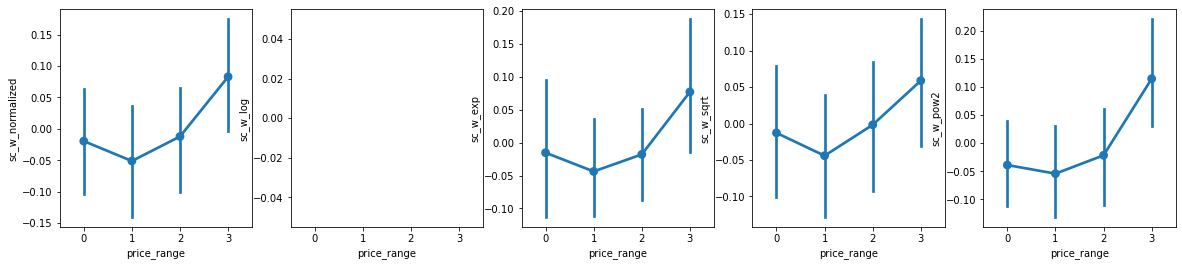

SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.9
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.885
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8775


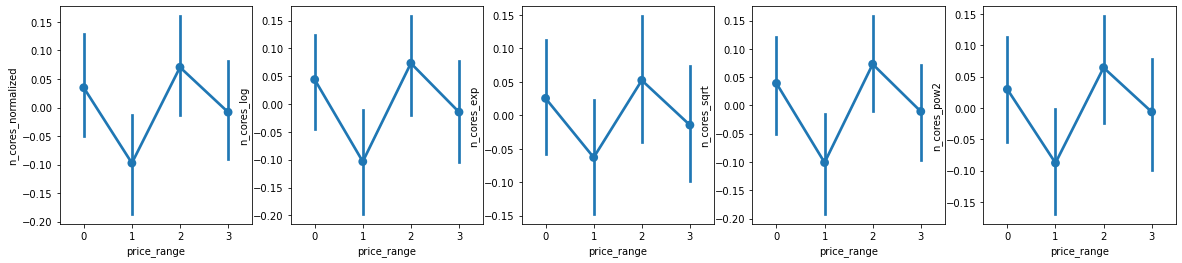

SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8825
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.9
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.885
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.89


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


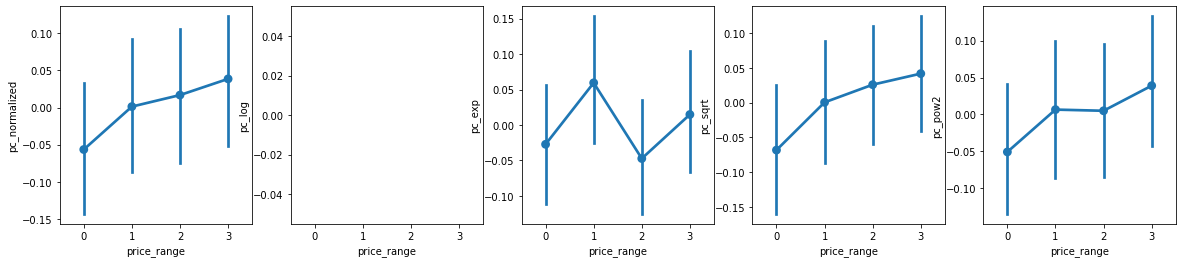

SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.86
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8875
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8975


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp2
  result = getattr(ufunc, method)(*inputs, **kwargs)


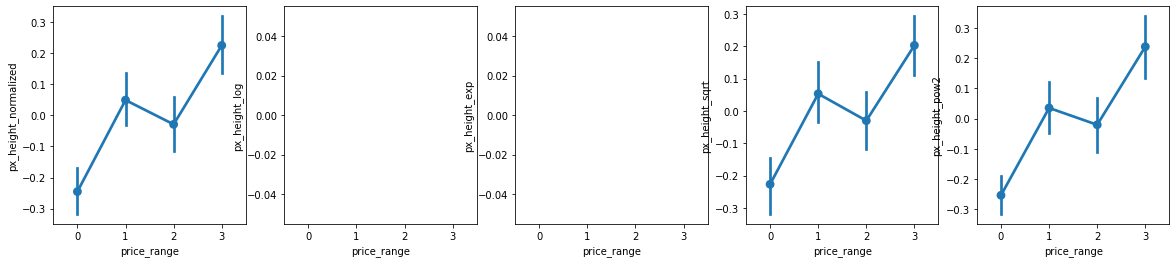

SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.89
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.89


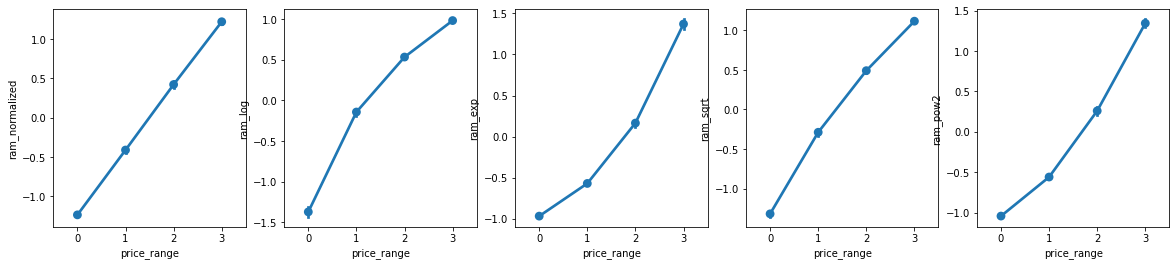

SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.855
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8375
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.88
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8625


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp2
  result = getattr(ufunc, method)(*inputs, **kwargs)


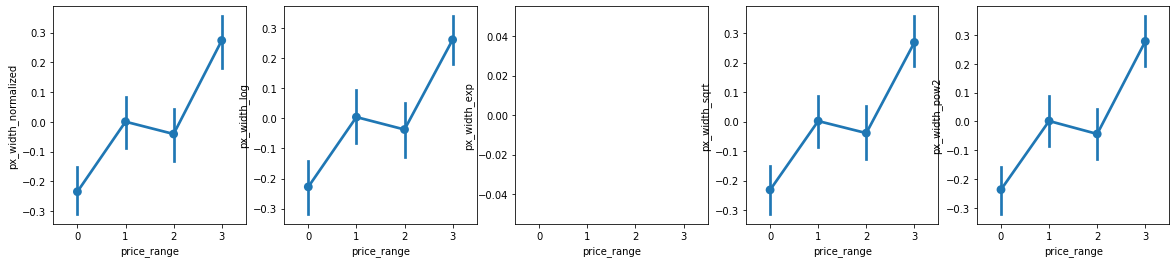

SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8825
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.89
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.89


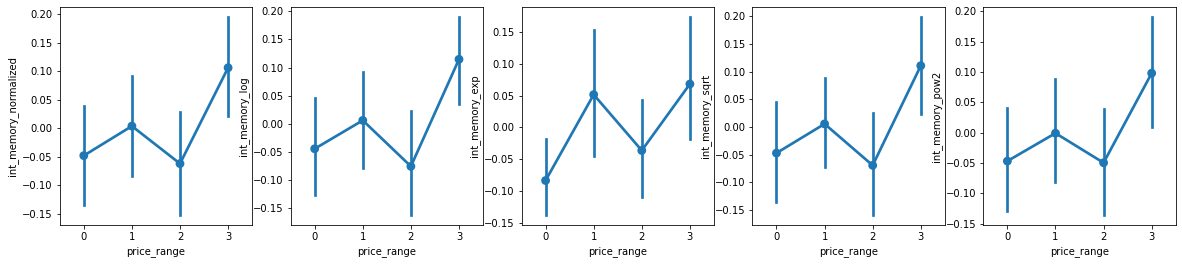

SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.89
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.885
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.885
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.9


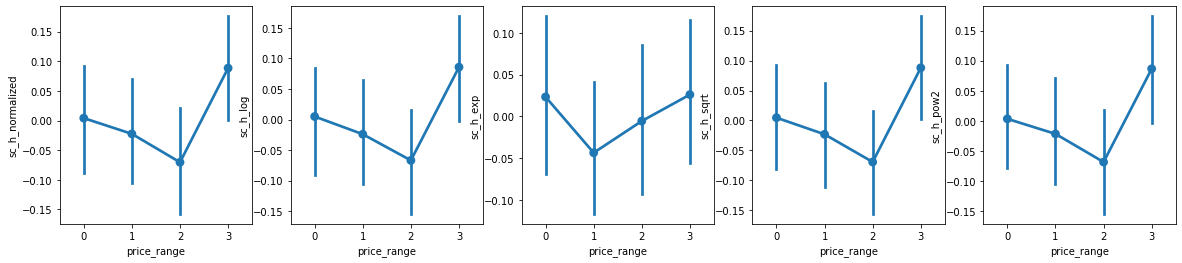

SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8925
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8925
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.89
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8875


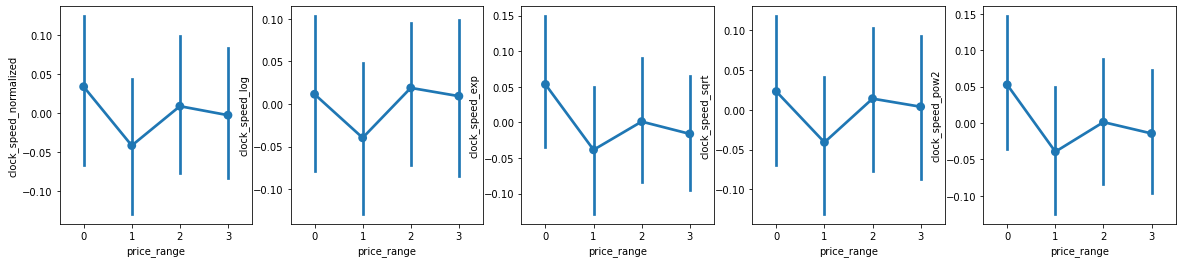

SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8875
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.9
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.885
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8975


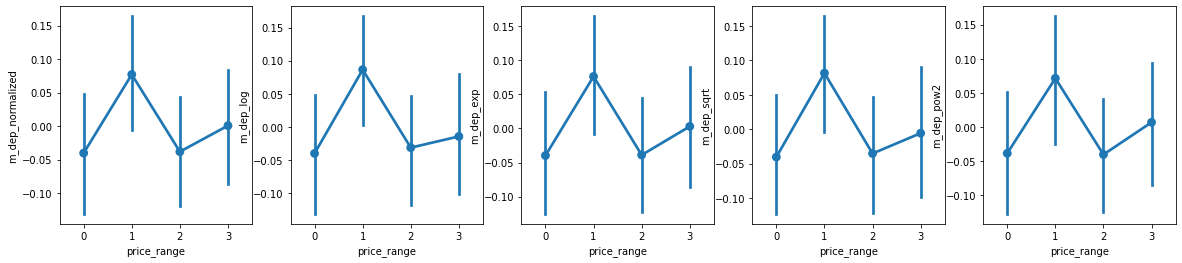

SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8925
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8875
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8925
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.885


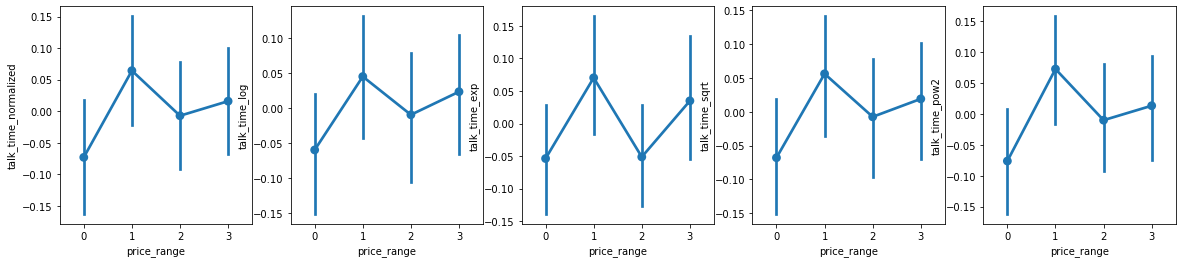

SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.89
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.885
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8875
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.885


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp2
  result = getattr(ufunc, method)(*inputs, **kwargs)


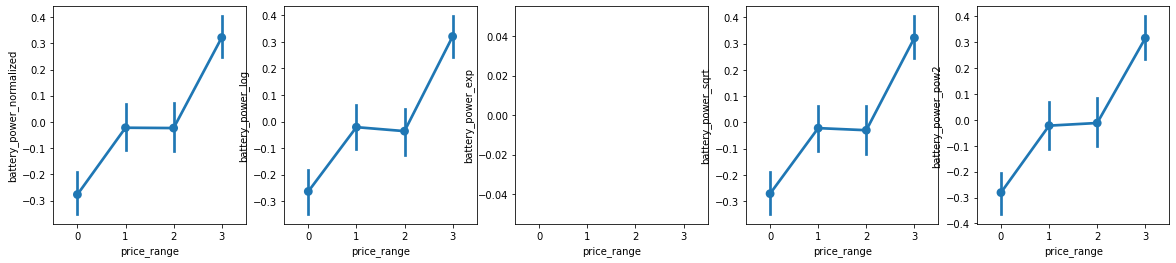

SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8975
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.9
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8825


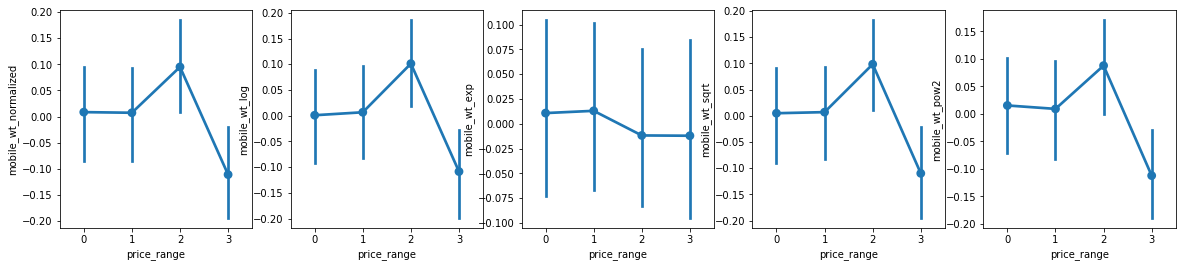

SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.885
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.875
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.885
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.89


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


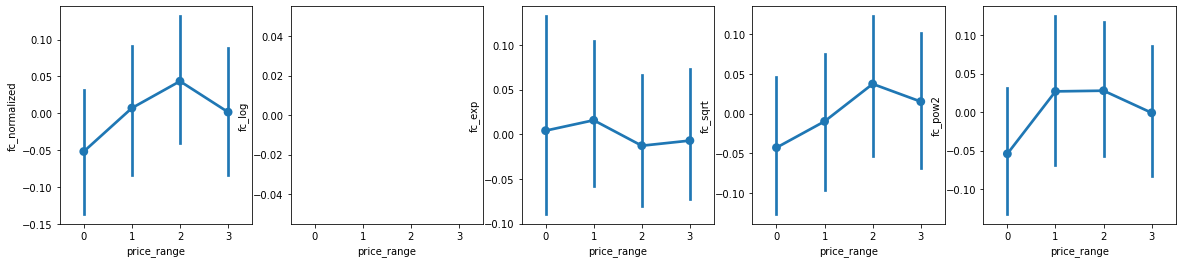

SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8975
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.9
SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8925


In [ ]:
for f in list(set(features) - set(categorical_features)):
  fig, ax = plt.subplots(1,5, figsize=(20, 4))
  
  f_val = train_df_org[f]
  if f == 'ram': f_val = f_val/1024 
  

  X.loc[:,f+'_normalized'] = ((f_val - f_val.mean())/f_val.std())
  sns.pointplot(y=X[f+'_normalized'], x=y, ax=ax[0])

  z = np.log(f_val)
  X.loc[:,f+'_log'] = ((z - z.mean())/z.std())
  #ax[1].scatter(zz, train_df_org['price_range'])
  sns.pointplot(y=X[f+'_log'], x=y, ax=ax[1])
  #ax[1].set_xlabel(f)

  z1 = np.exp2(f_val)
  X.loc[:,f+'_exp'] = ((z1 - z1.mean())/z1.std())
  #ax[2].scatter(zz1, train_df_org['price_range'])
  sns.pointplot(y=X[f+'_exp'], x=y, ax=ax[2])
  #ax[2].set_xlabel(f)

  z2 = np.sqrt(f_val)
  X.loc[:,f+'_sqrt'] = ((z2 - z2.mean())/z2.std())
  #ax[2].scatter(zz1, train_df_org['price_range'])
  sns.pointplot(y=X[f+'_sqrt'], x=y, ax=ax[3])

  z3 = f_val*f_val
  X.loc[:,f+'_pow2'] = ((z3 - z3.mean())/z3.std())
  #ax[2].scatter(zz1, train_df_org['price_range'])
  sns.pointplot(y=X[f+'_pow2'], x=y, ax=ax[4])

  plt.show()
  f_idx = features.index(f)

  if X[f+'_log'].isnull().sum()==0:
    new_f = features[:f_idx]+features[f_idx+1:]+[f+'_log']
    svm_w_kernel(X[new_f].values, y.values, kernel = 'rbf', multiclass_decision = 'ovr', train_size=0.8, print_f1 = False)

  if X[f+'_exp'].isnull().sum()==0:
    new_f = features[:f_idx]+features[f_idx+1:]+[f+'_exp']
    svm_w_kernel(X[new_f].values, y.values, kernel = 'rbf', multiclass_decision = 'ovr', train_size=0.8, print_f1 = False)

  new_f = features[:f_idx]+features[f_idx+1:]+[f+'_sqrt']
  svm_w_kernel(X[new_f].values, y.values, kernel = 'rbf', multiclass_decision = 'ovr', train_size=0.8, print_f1 = False)

  new_f = features[:f_idx]+features[f_idx+1:]+[f+'_pow2']
  svm_w_kernel(X[new_f].values, y.values, kernel = 'rbf', multiclass_decision = 'ovr', train_size=0.8, print_f1 = False)
  print('========================')


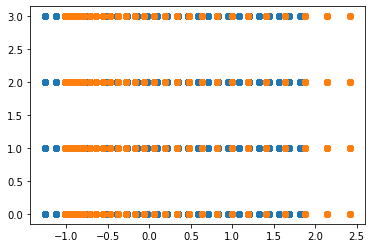

In [ ]:
plt.scatter(X['clock_speed_normalized'], y)
plt.scatter(X['clock_speed_exp'], y)



*   clock_speed: exp2 accuracy is 0.9 (vs 0.8875). The reason is that instances in class 0 is now slightly more distinguishable than those in classes 3 & 4 (look at instances in [0.1, 0.15] after transformation and normalization for class 0, before it was less than 0.10 that could be messed with those from classes 3 & 4
*  n_cores: by exp, when we use exp transformation, instances with higher cores have higher price and would get higher values for this feature and gets more distinguishable than instances in other classes
*   fc: by sqrt, class 0,1 got more distinguishable than classes 3 & 4 (0.9 vs 0.8875)
*   sc_w: by exp class 0 becomes more distinguishable than class 2 (look at high end ranges of instances in class 0, prviously it has overlap with the ranges in class 2, but now its more separable)



In [ ]:
X['area_pixel'] = X['px_height'] * X['px_width']
idx1, idx2 = features.index('px_height'), features.index('px_width')
idx1, idx2

(11, 12)

In [ ]:
new_f = features[:idx1]+features[idx2+1:]+['area_pixel']
svm_w_kernel(X[new_f].values, y.values, kernel = 'rbf', multiclass_decision = 'ovr', train_size=0.8)
print('========================')

SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.7925
Precision:  0.7964 [0.89473684 0.69298246 0.72043011 0.87755102]
Recall:  0.7914 [0.81730769 0.7745098  0.70526316 0.86868687]
Fscore:  0.7929 [0.85427136 0.73148148 0.71276596 0.87309645]


**Add Area Feature**

In [ ]:
X['area'] = X['sc_h'] * X['sc_w']
idx1, idx2 = features.index('sc_h'), features.index('sc_w')
idx1, idx2

(14, 15)

In [ ]:
new_f = features[:idx1]+features[idx2+1:]+['area']
svm_w_kernel(X[new_f].values, y.values, kernel = 'rbf', multiclass_decision = 'ovr', train_size=0.8)
print('========================')

SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.8975
Precision:  0.8999 [0.95918367 0.81981982 0.86170213 0.95876289]
Recall:  0.897 [0.90384615 0.89215686 0.85263158 0.93939394]
Fscore:  0.8978 [0.93069307 0.85446009 0.85714286 0.94897959]


**OneHotEncoding Features + Area + Bins + Transformation**

**Add code for this question here!!!!!!!!!**

In [ ]:
X_w_dummies.columns

Index(['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep',
       'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h',
       'sc_w', 'talk_time', 'blue_0', 'blue_1', 'dual_sim_0', 'dual_sim_1',
       'four_g_0', 'four_g_1', 'three_g_0', 'three_g_1', 'touch_screen_0',
       'touch_screen_1', 'wifi_0', 'wifi_1'],
      dtype='object')

In [ ]:
X_w_dummies_all = X_w_dummies.copy(deep = True)
X_w_dummies_all['batter_power_5_bins'], bins_5 = pd.cut(X_w_dummies_all['battery_power'], 5, retbins = True, labels=range(5))#labels = range(10)
X_w_dummies_all['area'] = X_w_dummies_all['sc_h'] * X_w_dummies_all['sc_w']

#exp transformation on clock_speed
f_val = train_df_org['clock_speed']
z1 = np.exp2(f_val)
X_w_dummies_all.loc[:,'clock_speed'+'_exp'] = ((z1 - z1.mean())/z1.std())

#exp transformation on n_cores
f_val = train_df_org['n_cores']
z1 = np.exp2(f_val)
X_w_dummies_all.loc[:,'n_cores'+'_exp'] = ((z1 - z1.mean())/z1.std())

#sqrt transformation on fc
f_val = train_df_org['fc']
z1 = np.sqrt(f_val)
X_w_dummies_all.loc[:,'fc'+'_sqrt'] = ((z1 - z1.mean())/z1.std())

In [ ]:
c = list(X_w_dummies_all.columns)
c

['battery_power',
 'clock_speed',
 'fc',
 'int_memory',
 'm_dep',
 'mobile_wt',
 'n_cores',
 'pc',
 'px_height',
 'px_width',
 'ram',
 'sc_h',
 'sc_w',
 'talk_time',
 'blue_0',
 'blue_1',
 'dual_sim_0',
 'dual_sim_1',
 'four_g_0',
 'four_g_1',
 'three_g_0',
 'three_g_1',
 'touch_screen_0',
 'touch_screen_1',
 'wifi_0',
 'wifi_1',
 'batter_power_5_bins',
 'area',
 'clock_speed_exp',
 'n_cores_exp',
 'fc_sqrt']

In [ ]:
#indexes for old version of features
idx0, idx1, idx2 = c.index('battery_power'), c.index('sc_h'), c.index('sc_w')
idx3, idx4, idx5 = c.index('clock_speed'), c.index('n_cores'), c.index('fc')

idx0, idx1, idx2, idx3, idx4, idx5, len(c)

(0, 11, 12, 1, 6, 2, 31)

In [ ]:
new_f = [c[1]] + c[3:6]+ c[7:11]+c[13:14]
svm_w_kernel(X_w_dummies_all[new_f].values, y.values, kernel = 'rbf', multiclass_decision = 'ovr', train_size=0.8)
print('========================')

SVM results for kernel rbf and Kernel coeff scale-- accuracy:  0.7925
Precision:  0.7951 [0.89       0.6952381  0.69       0.90526316]
Recall:  0.7916 [0.85576923 0.71568627 0.72631579 0.86868687]
Fscore:  0.793 [0.87254902 0.70531401 0.70769231 0.88659794]


# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
# Decision Tree Args Default Values:
# criterion: gini
# max_depth: None,--> nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split (default = 2) samples
# min_samples_split: 2
# min_samples_leaf: 1
def decision_tree(X, y, train_size=.8, print_f1 = True, grid_search = False):
  train_size = int(train_size * len(X))

  X_train = deepcopy(X[:train_size])
  y_train = deepcopy(y[:train_size])

  X_test = deepcopy(X[train_size:])
  y_test = deepcopy(y[train_size:])

  dtc = DecisionTreeClassifier()

  if grid_search:
    grid_params = {
        'criterion' : ['gini', 'entropy'],
        'max_depth' : [3, 5, 7, 10],
        'min_samples_split' : range(2, 10, 1),
        'min_samples_leaf' : range(2, 10, 1)
        }
    grid_search = GridSearchCV(dtc, grid_params, cv = 5, n_jobs = -1, verbose = 1)
    grid_search.fit(X_train, y_train)

    print('Grid Search best parameters')
    print(grid_search.best_params_)
    dtc = grid_search.best_estimator_

    print('Decision Tree Results with Best Estimator')
  else:
    dtc.fit(X_train, y_train)
    print('Decision Tree Results with Default Parameters')

  y_pred = dtc.predict(X_test)
  p, r, f, s = precision_recall_fscore_support(y_test, y_pred, average=None)

  
  print('Accuracy: ', dtc.score(X_test, y_test))
  print('Precision: ', round(np.mean(p), 4), p)
  print('Recall: ', round(np.mean(r),4), r)
  print('Fscore: ', round(np.mean(f),4), f)
  return dtc



In [ ]:
decision_tree(X[features].values, y.values, print_f1=True)

Decision Tree Results with Default Parameters
Accuracy:  0.8075
Precision:  0.8088 [0.89320388 0.69444444 0.72043011 0.92708333]
Recall:  0.806 [0.88461538 0.73529412 0.70526316 0.8989899 ]
Fscore:  0.8072 [0.88888889 0.71428571 0.71276596 0.91282051]


In [ ]:
dtc = decision_tree(X[features].values, y.values, print_f1=True, grid_search=True)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 956 tasks      | elapsed:    5.0s


Grid Search best parameters
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 3}
Decision Tree Results with Best Estimator
Accuracy:  0.88
Precision:  0.8788 [0.92307692 0.83333333 0.84615385 0.91262136]
Recall:  0.8791 [0.92307692 0.83333333 0.81052632 0.94949495]
Fscore:  0.8788 [0.92307692 0.83333333 0.82795699 0.93069307]


[Parallel(n_jobs=-1)]: Done 2560 out of 2560 | elapsed:   17.2s finished


**Pruning**: Prune Tree with Best Parameters

0.8675 9 0.0037315230799731995
Precision:  0.8682 [0.91262136 0.78899083 0.85057471 0.92079208]
Recall:  0.8663 [0.90384615 0.84313725 0.77894737 0.93939394]
Fscore:  0.8666 [0.90821256 0.81516588 0.81318681 0.93      ]


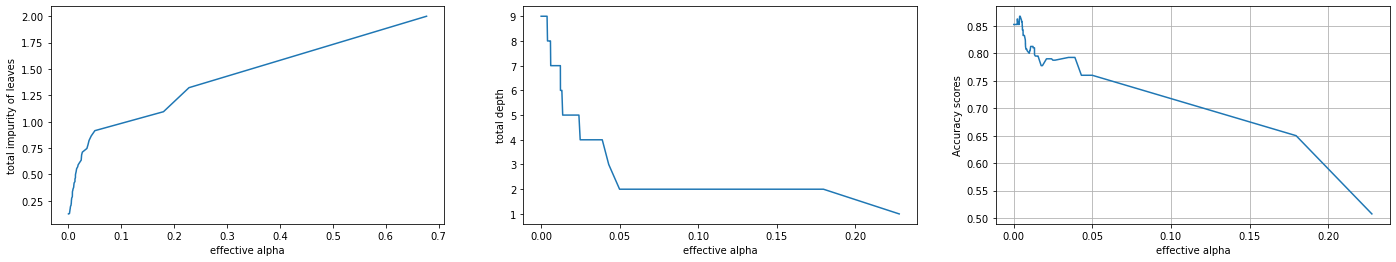

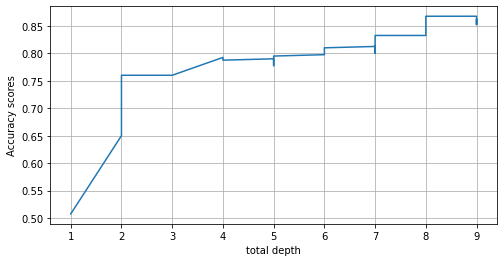

In [ ]:
# Prune Tree with Best Parameters
train_size = int(0.8 * len(X))
X_train = deepcopy(X.loc[:train_size, features])
y_train = deepcopy(y.loc[:train_size])
X_test = deepcopy(X.loc[train_size:, features])
y_test = deepcopy(y.loc[train_size:])

dtc = DecisionTreeClassifier(random_state=0,
                             criterion = 'entropy',
                             max_depth = 10, min_samples_leaf = 5,
                             min_samples_split = 3)
path = dtc.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

_, ax = plt.subplots(1,3, figsize=(24, 4))
ax[0].plot(ccp_alphas, impurities)
ax[0].set_xlabel("effective alpha")
ax[0].set_ylabel("total impurity of leaves")


dtcs = []
for ccp_alpha in ccp_alphas:
    dtc = DecisionTreeClassifier(random_state=0,
                                 criterion = 'entropy',
                                 max_depth = 10, min_samples_leaf = 5,
                                 min_samples_split = 3, ccp_alpha=ccp_alpha)
    dtc.fit(X_train, y_train)
    dtcs.append(dtc)



acc_scores = [dtc.score(X_test, y_test) for dtc in dtcs]
tree_depths = [dtc.tree_.max_depth for dtc in dtcs]

ax[1].plot(ccp_alphas[:-1], tree_depths[:-1])
ax[1].set_xlabel("effective alpha")
ax[1].set_ylabel("total depth")


plt.grid()
ax[2].plot(ccp_alphas[:-1], acc_scores[:-1])
ax[2].set_xlabel("effective alpha")
ax[2].set_ylabel("Accuracy scores")

_, ax = plt.subplots(1,1, figsize=(8, 4))
plt.grid()
ax.plot(tree_depths[:-1], acc_scores[:-1])
ax.set_xlabel("total depth")
ax.set_ylabel("Accuracy scores")


max_acc, opt_depth, opt_alpha, idx = 0, 0, 0, -1
for i in range(len(acc_scores)):
  if acc_scores[i]>max_acc:
    opt_depth = tree_depths[i]
    max_acc = acc_scores[i]
    opt_alpha = ccp_alphas[i]
    idx = i
print(max_acc, opt_depth, op۴t_alpha)
y_pred = dtcs[idx].predict(X_test)
p, r, f, s = precision_recall_fscore_support(y_test, y_pred, average=None)
print('Precision: ', round(np.mean(p), 4), p)
print('Recall: ', round(np.mean(r),4), r)
print('Fscore: ', round(np.mean(f),4), f)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# Random Forest Args Default Values:
# criterion: gini
# n_estimators: 100
# max_depth: None,--> nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split (default = 2) samples
# min_samples_split: 2
# min_samples_leaf: 1
def random_forest(X, y, train_size=.8, print_f1 = True, grid_search = False):
  train_size = int(train_size * len(X))

  X_train = deepcopy(X[:train_size])
  y_train = deepcopy(y[:train_size])

  X_test = deepcopy(X[train_size:])
  y_test = deepcopy(y[train_size:])

  rfc = RandomForestClassifier()

  if grid_search:
    grid_params = {
        'criterion' : ['gini', 'entropy'],
        'n_estimators': [20, 50, 100, 150, 200, 300, 400, 500],
        'max_depth' : [3, 5, 7, 10],
        'min_samples_split' : range(2, 10, 1),
        'min_samples_leaf' : range(2, 10, 1)
        }
    grid_search = GridSearchCV(rfc, grid_params, cv = 5, n_jobs = -1, verbose = 1)
    grid_search.fit(X_train, y_train)

    print('Grid Search best parameters')
    print(grid_search.best_params_)
    rfc = grid_search.best_estimator_

    print('Random Forest Results with Best Estimator')
  else:
    rfc.fit(X_train, y_train)
    print('Random Forest Results with Default Parameters')

  y_pred = rfc.predict(X_test)
  p, r, f, s = precision_recall_fscore_support(y_test, y_pred, average=None)

  
  print('Accuracy: ', rfc.score(X_test, y_test))
  print('Precision: ', round(np.mean(p), 4), p)
  print('Recall: ', round(np.mean(r),4), r)
  print('Fscore: ', round(np.mean(f),4), f)



In [ ]:
random_forest(X[features].values, y.values, print_f1=True)

Random Forest Results with Default Parameters
Accuracy:  0.8525
Precision:  0.8556 [0.93       0.75213675 0.82926829 0.91089109]
Recall:  0.8505 [0.89423077 0.8627451  0.71578947 0.92929293]
Fscore:  0.8509 [0.91176471 0.80365297 0.76836158 0.92      ]


In [ ]:
random_forest(X[features].values, y.values, print_f1=True, grid_search=True)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 2560 out of 2560 | elapsed:  9.2min finished


Grid Search best parameters
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Random Forest Results with Best Estimator
Accuracy:  0.89
Precision:  0.8911 [0.96       0.81651376 0.83870968 0.94897959]
Recall:  0.889 [0.92307692 0.87254902 0.82105263 0.93939394]
Fscore:  0.8897 [0.94117647 0.8436019  0.82978723 0.94416244]


# Time Series Prediction

In [ ]:
bitcoin_path = '/content/drive/MyDrive/Data Mining Class (Master)/HW3/Dataset/Bitcoin Historical Data - Investing.com.csv'
bitcoin_df = pd.read_csv(bitcoin_path)

In [ ]:
bitcoin_df.head(2)

,Date,Price,Open,High,Low,Vol.,Change %
0,"May 01, 2021","57,807.1","57,719.1","58,449.4","57,029.5",63.41K,0.15%
1,"Apr 30, 2021","57,720.3","53,562.3","57,925.6","53,088.7",103.74K,7.77%


In [ ]:
for col in bitcoin_df.columns:
  if col == 'Date':
    bitcoin_df[col] = pd.to_datetime(bitcoin_df[col])
  elif col in ['Price', 'Open', 'High']:
    bitcoin_df[col] = bitcoin_df[col].str.replace(',', '').astype('float64') 

bitcoin_df= bitcoin_df.sort_values(by = 'Date', ascending=True).reset_index(drop = True)

In [ ]:
bitcoin_df.head(2)

,Date,Price,Open,High,Low,Vol.,Change %
0,2010-07-18,0.1,0.0,0.1,0.1,0.08K,0.00%
1,2010-07-19,0.1,0.1,0.1,0.1,0.57K,0.00%


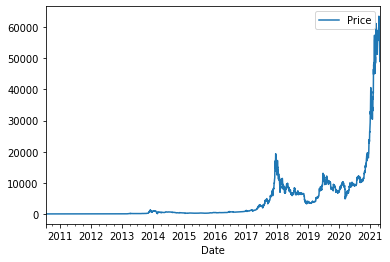

In [ ]:
bitcoin_df.plot('Date', 'Price')

In [ ]:
bitcoin_train_df = bitcoin_df[bitcoin_df['Date']<='2020-01-01']
bitcoin_test_df = bitcoin_df[bitcoin_df['Date']>='2020-01-02']
print('train size: {}, test size: {}, all: {}'.format(len(bitcoin_train_df), len(bitcoin_test_df), len(bitcoin_df)))


train size: 3455, test size: 486, all: 3941


In [ ]:
def accuracy_reg(y_true, y_pred, error_bound = 0.05):
  y_ratio = [x/y for x, y in zip(y_true , y_pred)]
  count = 0
  for x in y_ratio:
    if x >= 1-error_bound and x<= 1+ error_bound:
      count+=1
  #count = len(y_ratio[(y_ratio>= 1 - error_bound) & (y_ratio<= 1 + error_bound)])
  print(count, len(y_true), len(y_pred))
  return (count/len(y_true)*100.0)

In [ ]:
!pip install statsmodels --upgrade

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.7/dist-packages (0.12.2)


**1)Autoregression (AR)**


*   models the next step in the sequence as a linear function of the observations at prior time steps.
*   suitable for univariate time series without trend and seasonal components
* A rolling forecasting procedure



In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from random import random
# fit model
historical_data = list(bitcoin_train_df['Price'])
y_prediction_test = []
for timestamp in range(len(bitcoin_test_df)):
  ar = AutoReg(historical_data, lags=1)#500
  model_ar = ar.fit()
  # make prediction

  # for first timestamp, get the prediction for the whole training data and store it
  if timestamp == 0:
    y_prediction_train = model_ar.predict(1, len(bitcoin_train_df)-1)

  # predict for the timestamp-th instance in test set
  pred = model_ar.predict(len(bitcoin_train_df)+timestamp, len(bitcoin_train_df)+timestamp)
  y_prediction_test.append(pred)

  # append the real value of timestamp-th isntance to training set and re-train the model
  historical_data.append(bitcoin_test_df['Price'].values[timestamp])
  
  #y_prediction_test = model_ar.predict(len(bitcoin_train_df), len(bitcoin_train_df)+len(bitcoin_test_df)-1)

print(len(y_prediction_train), len(y_prediction_test))

3454 486


train error: 204.46173709728777, test error: 1084.8582458258516
2030 3454 3454
413 486 486
train accuracy 5%: 58.77243775332948, test accuracy 5%: 84.97942386831275


Text(0.5, 1.0, 'Whole Data')

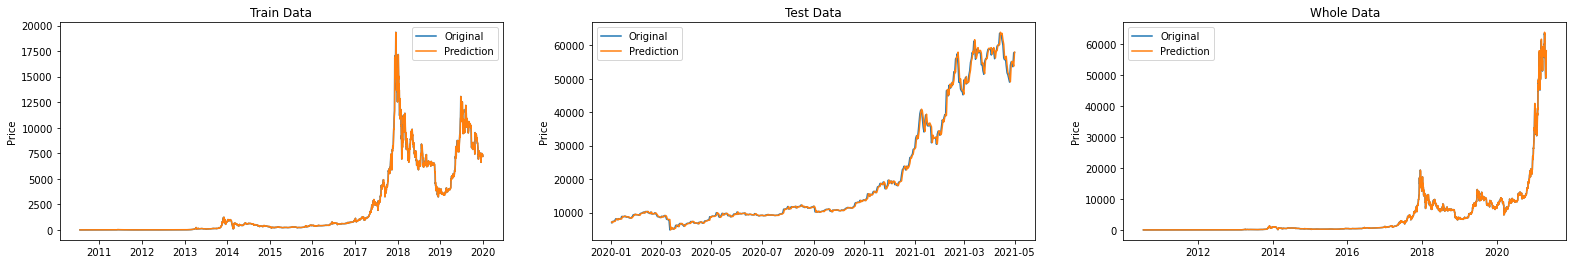

In [ ]:
train_rmse = mean_squared_error(bitcoin_train_df['Price'].values[1:], y_prediction_train, squared=False)
test_rmse = mean_squared_error(bitcoin_test_df['Price'].values, y_prediction_test, squared=False)
print('train error: {}, test error: {}'.format(train_rmse, test_rmse))


train_acc = accuracy_reg(bitcoin_train_df['Price'].values[1:], y_prediction_train, error_bound=0.05)
test_acc = accuracy_reg(bitcoin_test_df['Price'].values, y_prediction_test, error_bound=0.05)
print('train accuracy 5%: {}, test accuracy 5%: {}'.format(train_acc, test_acc))

_, ax = plt.subplots(1,3, figsize=(27, 4))
ax[0].plot(bitcoin_train_df['Date'].values[1:], bitcoin_train_df['Price'].values[1:], label = 'Original')
ax[0].plot(bitcoin_train_df['Date'].values[1:], y_prediction_train, label = 'Prediction')
ax[0].legend()
ax[0].set_ylabel('Price')
ax[0].set_title('Train Data')

ax[1].plot(bitcoin_test_df['Date'], bitcoin_test_df['Price'], label = 'Original')
ax[1].plot(bitcoin_test_df['Date'], y_prediction_test, label = 'Prediction')
ax[1].legend()
ax[1].set_ylabel('Price')
ax[1].set_title('Test Data')

ax[2].plot(bitcoin_df['Date'].values[1:],
           list(bitcoin_train_df['Price'].values[1:])+list(bitcoin_test_df['Price'].values)
          , label = 'Original')
ax[2].plot(bitcoin_df['Date'].values[1:],
           list(y_prediction_train)+list(y_prediction_test)
           , label = 'Prediction')
ax[2].legend()
ax[2].set_ylabel('Price')
ax[2].set_title('Whole Data')

**2)Moving Average**


*   models the next step in the sequence as a linear function of the residual errors from a mean process at prior time steps.
*   suitable for univariate time series without trend and seasonal components.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from random import random
# fit model
historical_data = list(bitcoin_train_df['Price'])
y_prediction_test = []
for timestamp in range(len(bitcoin_test_df)):
  #simple moving average
  ma_s = ARIMA(historical_data, order=(0, 0, 1))
  model_ma_s = ma_s.fit()
  # make prediction

  # for first timestamp, get the prediction for the whole training data and store it
  if timestamp == 0:
    y_prediction_train = model_ma_s.predict(0, len(bitcoin_train_df)-1)

  # predict for the timestamp-th instance in test set
  pred = model_ma_s.predict(len(bitcoin_train_df)+timestamp, len(bitcoin_train_df)+timestamp)
  y_prediction_test.append(pred)

  # append the real value of timestamp-th isntance to training set and re-train the model
  historical_data.append(bitcoin_test_df['Price'].values[timestamp])
  
  #y_prediction_test = model_ar.predict(len(bitcoin_train_df), len(bitcoin_train_df)+len(bitcoin_test_df)-1)

print(len(y_prediction_train), len(y_prediction_test))

3455 486


train error: 1786.3782441068747, test error: 12925.85145114704
36 3455 3455
5 486 486
train accuracy 5%: 1.0419681620839363, test accuracy 5%: 1.02880658436214


Text(0.5, 1.0, 'Whole Data')

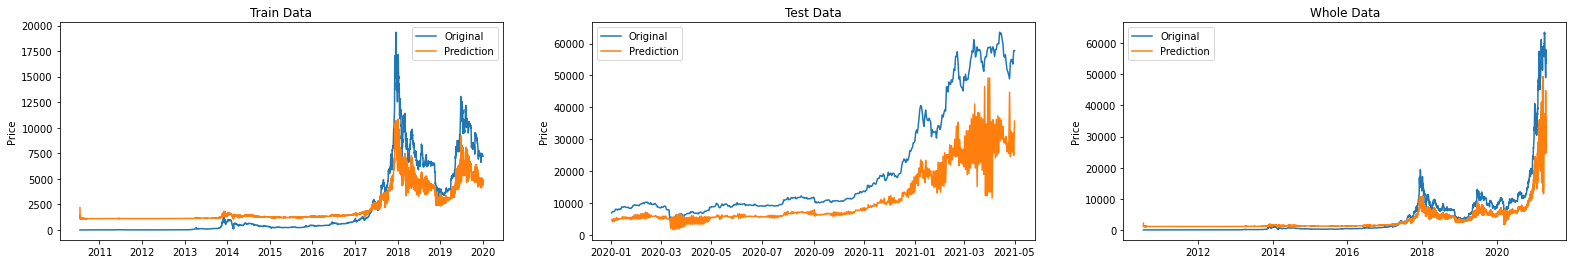

In [ ]:
train_rmse = mean_squared_error(bitcoin_train_df['Price'].values, y_prediction_train, squared=False)
test_rmse = mean_squared_error(bitcoin_test_df['Price'].values, y_prediction_test, squared=False)
print('train error: {}, test error: {}'.format(train_rmse, test_rmse))


train_acc = accuracy_reg(bitcoin_train_df['Price'].values, y_prediction_train, error_bound=0.05)
test_acc = accuracy_reg(bitcoin_test_df['Price'].values, y_prediction_test, error_bound=0.05)
print('train accuracy 5%: {}, test accuracy 5%: {}'.format(train_acc, test_acc))

_, ax = plt.subplots(1,3, figsize=(27, 4))
ax[0].plot(bitcoin_train_df['Date'].values, bitcoin_train_df['Price'].values, label = 'Original')
ax[0].plot(bitcoin_train_df['Date'].values, y_prediction_train, label = 'Prediction')
ax[0].legend()
ax[0].set_ylabel('Price')
ax[0].set_title('Train Data')

ax[1].plot(bitcoin_test_df['Date'], bitcoin_test_df['Price'], label = 'Original')
ax[1].plot(bitcoin_test_df['Date'], y_prediction_test, label = 'Prediction')
ax[1].legend()
ax[1].set_ylabel('Price')
ax[1].set_title('Test Data')

ax[2].plot(bitcoin_df['Date'].values,
           list(bitcoin_train_df['Price'].values)+list(bitcoin_test_df['Price'].values)
          , label = 'Original')
ax[2].plot(bitcoin_df['Date'].values,
           list(y_prediction_train)+list(y_prediction_test)
           , label = 'Prediction')
ax[2].legend()
ax[2].set_ylabel('Price')
ax[2].set_title('Whole Data')

**3)Prophet for Time series prediction**


*  open-source library by Facebook designed for making forecasts for univariate time series datasets
*    additive time series forecasting model, and the implementation supports trends, seasonality, and holidays
* Resource: https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

In [ ]:
from fbprophet import Prophet
from random import random
from pandas import to_datetime
# fit model
historical_data = pd.DataFrame(data = bitcoin_train_df[['Date','Price']].values, columns = ['ds', 'y'])
#historical_data.columns = ['ds', 'y']
historical_data['ds']= to_datetime(historical_data['ds'])
y_prediction_test = []
for timestamp in range(len(bitcoin_test_df)):
  #simple moving average
  proph = Prophet()#ARIMA(historical_data, order=(0, 0, 1))
  model_proph = proph.fit(historical_data)
  # make prediction

  # for first timestamp, get the prediction for the whole training data and store it
  if timestamp == 0:
    y_prediction_train = model_proph.predict(historical_data)

  # predict for the timestamp-th instance in test set
  future = pd.DataFrame({'ds': [bitcoin_test_df['Date'].values[timestamp]]})
  #future.columns = ['ds']
  future['ds']= to_datetime(future['ds'])

  pred = model_proph.predict(future)
  y_prediction_test.append(pred['yhat'].values[0])

  # append the real value of timestamp-th isntance to training set and re-train the model
  #historical_data.append(bitcoin_test_df['Price'].values[timestamp])
  historical_data = historical_data.append({'ds': pred['ds'].values[0], 'Price': pred['yhat'].values[0]}, ignore_index=True)
  
  #break
  #y_prediction_test = model_ar.predict(len(bitcoin_train_df), len(bitcoin_train_df)+len(bitcoin_test_df)-1)

print(len(y_prediction_train), len(y_prediction_test))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

3455 486


train error: 1432.8616850082872, test error: 22246.027632499416
219 3455 3455
17 486 486
train accuracy 5%: 6.338639652677279, test accuracy 5%: 3.4979423868312756


Text(0.5, 1.0, 'Whole Data')

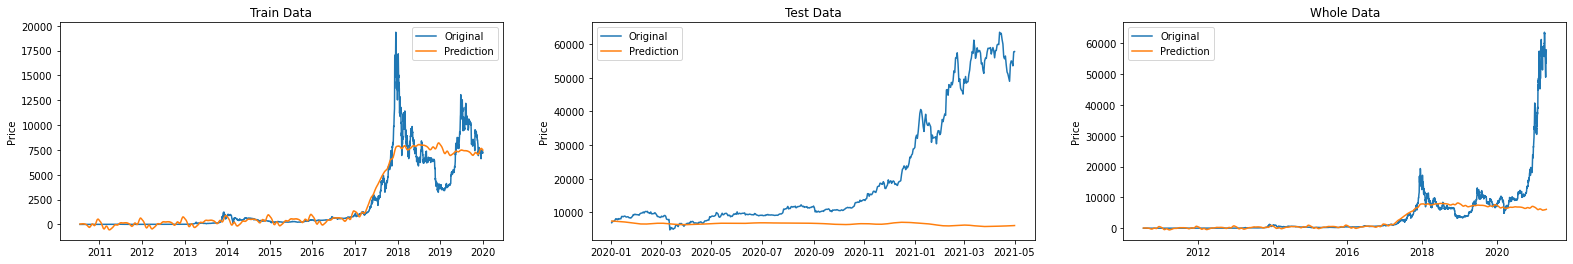

In [ ]:
train_rmse = mean_squared_error(bitcoin_train_df['Price'].values, y_prediction_train['yhat'].values, squared=False)
test_rmse = mean_squared_error(bitcoin_test_df['Price'].values, y_prediction_test, squared=False)
print('train error: {}, test error: {}'.format(train_rmse, test_rmse))


train_acc = accuracy_reg(bitcoin_train_df['Price'].values, y_prediction_train['yhat'].values, error_bound=0.05)
test_acc = accuracy_reg(bitcoin_test_df['Price'].values, y_prediction_test, error_bound=0.05)
print('train accuracy 5%: {}, test accuracy 5%: {}'.format(train_acc, test_acc))

_, ax = plt.subplots(1,3, figsize=(27, 4))
ax[0].plot(bitcoin_train_df['Date'].values, bitcoin_train_df['Price'].values, label = 'Original')
ax[0].plot(bitcoin_train_df['Date'].values, y_prediction_train['yhat'].values, label = 'Prediction')
ax[0].legend()
ax[0].set_ylabel('Price')
ax[0].set_title('Train Data')

ax[1].plot(bitcoin_test_df['Date'], bitcoin_test_df['Price'], label = 'Original')
ax[1].plot(bitcoin_test_df['Date'], y_prediction_test, label = 'Prediction')
ax[1].legend()
ax[1].set_ylabel('Price')
ax[1].set_title('Test Data')

ax[2].plot(bitcoin_df['Date'].values,
           list(bitcoin_train_df['Price'].values)+list(bitcoin_test_df['Price'].values)
          , label = 'Original')
ax[2].plot(bitcoin_df['Date'].values,
           list(y_prediction_train['yhat'].values)+list(y_prediction_test)
           , label = 'Prediction')
ax[2].legend()
ax[2].set_ylabel('Price')
ax[2].set_title('Whole Data')

**4)Autoregressive Integrated Moving Average (ARIMA)**


*   models the next step in the sequence as a linear function of the differenced observations and residual errors at prior time steps.
*   suitable for univariate time series with trend and without seasonal components.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from random import random
# fit model
historical_data = list(bitcoin_train_df['Price'])
y_prediction_test = []
for timestamp in range(len(bitcoin_test_df)):
  ma = ARIMA(historical_data, order=(1, 1, 1))
  model_ma = ma.fit()
  # make prediction

  # for first timestamp, get the prediction for the whole training data and store it
  if timestamp == 0:
    y_prediction_train = model_ma.predict(0, len(bitcoin_train_df)-1)

  # predict for the timestamp-th instance in test set
  pred = model_ma.predict(len(bitcoin_train_df)+timestamp, len(bitcoin_train_df)+timestamp)
  y_prediction_test.append(pred)

  # append the real value of timestamp-th isntance to training set and re-train the model
  historical_data.append(bitcoin_test_df['Price'].values[timestamp])
  
  #y_prediction_test = model_ar.predict(len(bitcoin_train_df), len(bitcoin_train_df)+len(bitcoin_test_df)-1)

print(len(y_prediction_train), len(y_prediction_test))

3455 486


train error: 203.92150351047783, test error: 1090.8758581140335
2811 3455 3455
413 486 486
train accuracy 5%: 81.3603473227207, test accuracy 5%: 84.97942386831275


Text(0.5, 1.0, 'Whole Data')

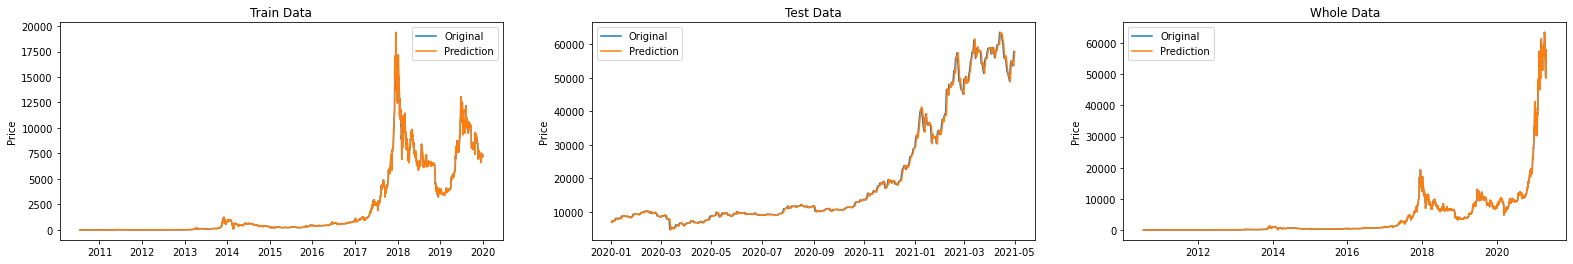

In [ ]:
train_rmse = mean_squared_error(bitcoin_train_df['Price'].values, y_prediction_train, squared=False)
test_rmse = mean_squared_error(bitcoin_test_df['Price'].values, y_prediction_test, squared=False)
print('train error: {}, test error: {}'.format(train_rmse, test_rmse))


train_acc = accuracy_reg(bitcoin_train_df['Price'].values, y_prediction_train, error_bound=0.05)
test_acc = accuracy_reg(bitcoin_test_df['Price'].values, y_prediction_test, error_bound=0.05)
print('train accuracy 5%: {}, test accuracy 5%: {}'.format(train_acc, test_acc))

_, ax = plt.subplots(1,3, figsize=(27, 4))
ax[0].plot(bitcoin_train_df['Date'].values, bitcoin_train_df['Price'].values, label = 'Original')
ax[0].plot(bitcoin_train_df['Date'].values, y_prediction_train, label = 'Prediction')
ax[0].legend()
ax[0].set_ylabel('Price')
ax[0].set_title('Train Data')

ax[1].plot(bitcoin_test_df['Date'], bitcoin_test_df['Price'], label = 'Original')
ax[1].plot(bitcoin_test_df['Date'], y_prediction_test, label = 'Prediction')
ax[1].legend()
ax[1].set_ylabel('Price')
ax[1].set_title('Test Data')

ax[2].plot(bitcoin_df['Date'].values,
           list(bitcoin_train_df['Price'].values)+list(bitcoin_test_df['Price'].values)
          , label = 'Original')
ax[2].plot(bitcoin_df['Date'].values,
           list(y_prediction_train)+list(y_prediction_test)
           , label = 'Prediction')
ax[2].legend()
ax[2].set_ylabel('Price')
ax[2].set_title('Whole Data')

**Modeling ARIMA without rolling forcast**: This can result in having flat predictions after a few timestamps. We thus need to user previous observations as training data point for the model and retrain it.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from random import random
# fit model
historical_data = list(bitcoin_train_df['Price'])
y_prediction_test = []

ma = ARIMA(historical_data, order=(1, 1, 1),
           seasonal_order=(1, 0, 1, 12),
           enforce_stationarity=False,
           enforce_invertibility=False)
model_ma = ma.fit()
y_prediction_train = model_ma.predict(0, len(bitcoin_train_df)-1)

print(model_ma.aic)
# for timestamp in range(len(bitcoin_test_df)):
#   ma = ARIMA(historical_data, order=(1, 1, 1))
#   model_ma = ma.fit()
#   # make prediction

#   # for first timestamp, get the prediction for the whole training data and store it
#   if timestamp == 0:
    

#   # predict for the timestamp-th instance in test set
#   pred = model_ma.predict(len(bitcoin_train_df)+timestamp, len(bitcoin_train_df)+timestamp)
#   y_prediction_test.append(pred)

#   # append the real value of timestamp-th isntance to training set and re-train the model
#   historical_data.append(bitcoin_test_df['Price'].values[timestamp])
  
#   #y_prediction_test = model_ar.predict(len(bitcoin_train_df), len(bitcoin_train_df)+len(bitcoin_test_df)-1)

# print(len(y_prediction_train), len(y_prediction_test))

46369.99759942424


In [ ]:
print(model_ma.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7478      0.032    -23.012      0.000      -0.812      -0.684
ma.L1          0.7952      0.031     26.039      0.000       0.735       0.855
ar.S.L12       0.3486      0.102      3.407      0.001       0.148       0.549
ma.S.L12      -0.3868      0.101     -3.844      0.000      -0.584      -0.190
sigma2      4.182e+04    225.626    185.368      0.000    4.14e+04    4.23e+04


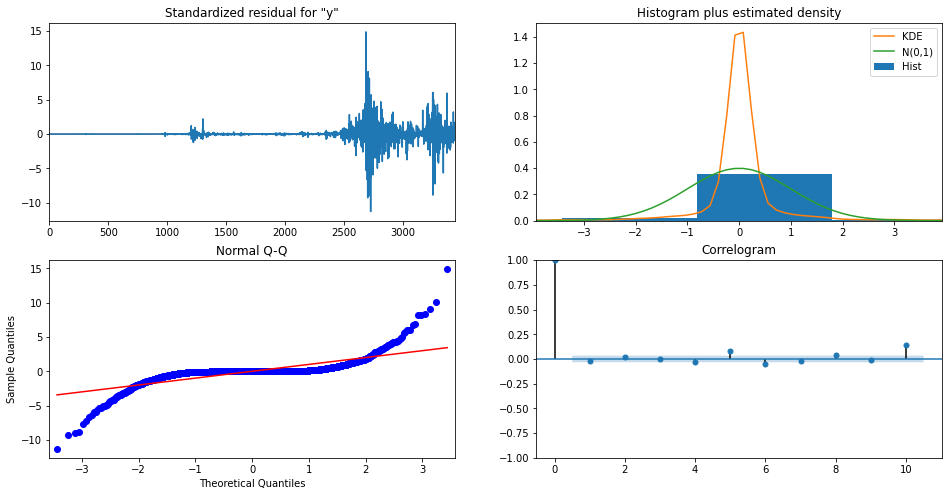

In [ ]:
model_ma.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
len(historical_data)

3455

In [ ]:
pred = model_ma.get_forecast(steps=len(bitcoin_test_df)-1)
#model_ma.get_prediction(start=len(historical_data), end = len(bitcoin_train_df)+len(bitcoin_test_df)-1, dynamic=False)
pred_ci = pred.conf_int()

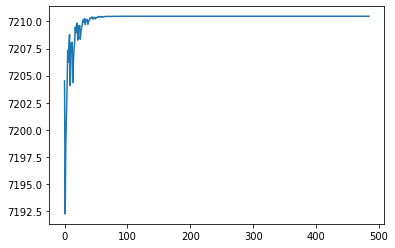

In [ ]:
plt.plot(pred.predicted_mean, label='One-step ahead Forecast', )

**5)Simple Exponential Smoothing (SES)**


*   models the next time step as an exponentially weighted linear function of observations at prior time steps.
*   suitable for univariate time series without trend and seasonal components.

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# fit model
historical_data = list(bitcoin_train_df['Price'])
y_prediction_test = []
for timestamp in range(len(bitcoin_test_df)):
  ses = SimpleExpSmoothing(historical_data)
  model_ses = ses.fit()
  # make prediction

  # for first timestamp, get the prediction for the whole training data and store it
  if timestamp == 0:
    y_prediction_train = model_ses.predict(1, len(bitcoin_train_df)-1)

  # predict for the timestamp-th instance in test set
  pred = model_ses.predict(len(bitcoin_train_df)+timestamp, len(bitcoin_train_df)+timestamp)
  y_prediction_test.append(pred)

  # append the real value of timestamp-th isntance to training set and re-train the model
  historical_data.append(bitcoin_test_df['Price'].values[timestamp])
  
  #y_prediction_test = model_ar.predict(len(bitcoin_train_df), len(bitcoin_train_df)+len(bitcoin_test_df)-1)

print(len(y_prediction_train), len(y_prediction_test))

3454 486


train error: 204.53847752459498, test error: 1082.601079960296
2813 3454 3454
415 486 486
train accuracy 5%: 81.44180660104226, test accuracy 5%: 85.39094650205762


Text(0.5, 1.0, 'Whole Data')

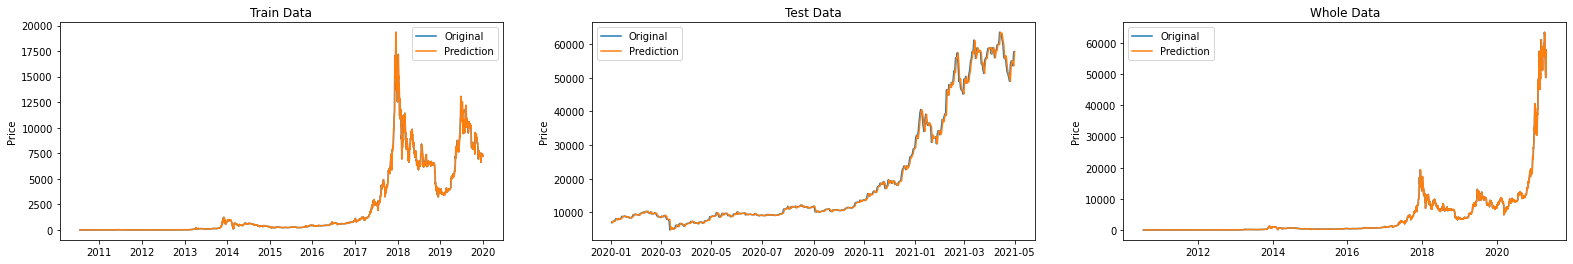

In [ ]:
train_rmse = mean_squared_error(bitcoin_train_df['Price'].values[1:], y_prediction_train, squared=False)
test_rmse = mean_squared_error(bitcoin_test_df['Price'].values, y_prediction_test, squared=False)
print('train error: {}, test error: {}'.format(train_rmse, test_rmse))


train_acc = accuracy_reg(bitcoin_train_df['Price'].values[1:], y_prediction_train, error_bound=0.05)
test_acc = accuracy_reg(bitcoin_test_df['Price'].values, y_prediction_test, error_bound=0.05)
print('train accuracy 5%: {}, test accuracy 5%: {}'.format(train_acc, test_acc))

_, ax = plt.subplots(1,3, figsize=(27, 4))
ax[0].plot(bitcoin_train_df['Date'].values[1:], bitcoin_train_df['Price'].values[1:], label = 'Original')
ax[0].plot(bitcoin_train_df['Date'].values[1:], y_prediction_train, label = 'Prediction')
ax[0].legend()
ax[0].set_ylabel('Price')
ax[0].set_title('Train Data')

ax[1].plot(bitcoin_test_df['Date'], bitcoin_test_df['Price'], label = 'Original')
ax[1].plot(bitcoin_test_df['Date'], y_prediction_test, label = 'Prediction')
ax[1].legend()
ax[1].set_ylabel('Price')
ax[1].set_title('Test Data')

ax[2].plot(bitcoin_df['Date'].values[1:],
           list(bitcoin_train_df['Price'].values[1:])+list(bitcoin_test_df['Price'].values)
          , label = 'Original')
ax[2].plot(bitcoin_df['Date'].values[1:],
           list(y_prediction_train)+list(y_prediction_test)
           , label = 'Prediction')
ax[2].legend()
ax[2].set_ylabel('Price')
ax[2].set_title('Whole Data')

**6)Holt Winter’s Exponential Smoothing (HWES)**


*   models the next time step as an exponentially weighted linear function of observations at prior time steps, taking trends and seasonality into account.
*   suitable for univariate time series with trend and/or seasonal components.

In [ ]:
from statsmodels.tsa.holtwinters import Holt

# fit model
historical_data = list(bitcoin_train_df['Price'])
y_prediction_test = []
for timestamp in range(len(bitcoin_test_df)):
  holt = Holt(historical_data, exponential=True, damped=True)
  model_holt = holt.fit()
  # make prediction

  # for first timestamp, get the prediction for the whole training data and store it
  if timestamp == 0:
    y_prediction_train = model_holt.predict(1, len(bitcoin_train_df)-1)

  # predict for the timestamp-th instance in test set
  pred = model_holt.predict(len(bitcoin_train_df)+timestamp, len(bitcoin_train_df)+timestamp)
  y_prediction_test.append(pred)

  # append the real value of timestamp-th isntance to training set and re-train the model
  historical_data.append(bitcoin_test_df['Price'].values[timestamp])
  
  #y_prediction_test = model_ar.predict(len(bitcoin_train_df), len(bitcoin_train_df)+len(bitcoin_test_df)-1)

print(len(y_prediction_train), len(y_prediction_test))

3454 486


train error: 204.5754729759361, test error: 21683.516740373798
2812 3454 3454
23 486 486
train accuracy 5%: 81.4128546612623, test accuracy 5%: 4.732510288065844


Text(0.5, 1.0, 'Whole Data')

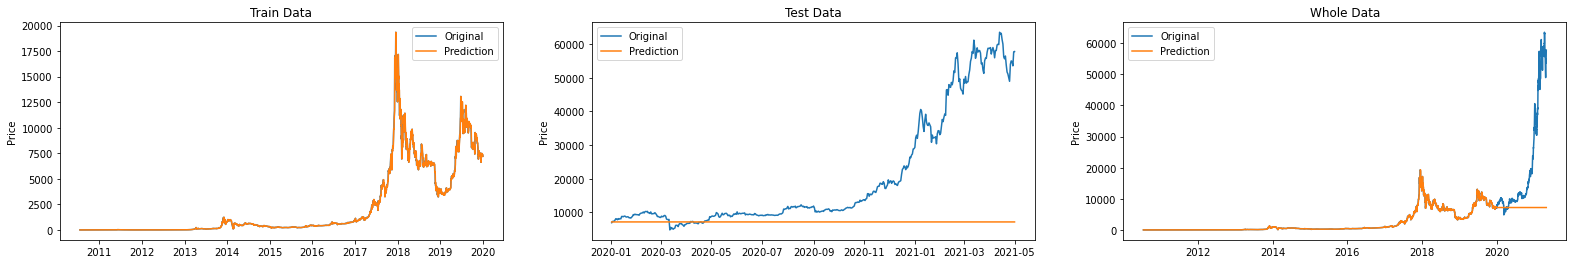

In [ ]:
train_rmse = mean_squared_error(bitcoin_train_df['Price'].values[1:], y_prediction_train, squared=False)
test_rmse = mean_squared_error(bitcoin_test_df['Price'].values, fcast3, squared=False)
print('train error: {}, test error: {}'.format(train_rmse, test_rmse))


train_acc = accuracy_reg(bitcoin_train_df['Price'].values[1:], y_prediction_train, error_bound=0.05)
test_acc = accuracy_reg(bitcoin_test_df['Price'].values, fcast3, error_bound=0.05)
print('train accuracy 5%: {}, test accuracy 5%: {}'.format(train_acc, test_acc))

_, ax = plt.subplots(1,3, figsize=(27, 4))
ax[0].plot(bitcoin_train_df['Date'].values[1:], bitcoin_train_df['Price'].values[1:], label = 'Original')
ax[0].plot(bitcoin_train_df['Date'].values[1:], y_prediction_train, label = 'Prediction')
ax[0].legend()
ax[0].set_ylabel('Price')
ax[0].set_title('Train Data')

ax[1].plot(bitcoin_test_df['Date'], bitcoin_test_df['Price'], label = 'Original')
ax[1].plot(bitcoin_test_df['Date'], fcast3, label = 'Prediction')
ax[1].legend()
ax[1].set_ylabel('Price')
ax[1].set_title('Test Data')

ax[2].plot(bitcoin_df['Date'].values[1:],
           list(bitcoin_train_df['Price'].values[1:])+list(bitcoin_test_df['Price'].values)
          , label = 'Original')
ax[2].plot(bitcoin_df['Date'].values[1:],
           list(y_prediction_train)+list(fcast3)
           , label = 'Prediction')
ax[2].legend()
ax[2].set_ylabel('Price')
ax[2].set_title('Whole Data')

**7)LSTM**

In [ ]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
#LSTM is sensitive to scale of input data, so we rescale everything between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
bitcoin_df_scaled = scaler.fit_transform(bitcoin_df['Price'].values.reshape(-1,1))

bitcoin_train_df_scaled = bitcoin_df_scaled[bitcoin_df['Date']<='2020-01-01']
bitcoin_test_df_scaled = bitcoin_df_scaled[bitcoin_df['Date']>='2020-01-02']

In [ ]:
len(bitcoin_test_df_scaled)

486

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 1
trainX, trainY = create_dataset(bitcoin_train_df_scaled, look_back)
testX, testY = create_dataset(bitcoin_test_df_scaled, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
3453/3453 - 5s - loss: 5.7039e-04
Epoch 2/50
3453/3453 - 3s - loss: 1.4556e-05
Epoch 3/50
3453/3453 - 4s - loss: 1.4916e-05
Epoch 4/50
3453/3453 - 4s - loss: 1.5956e-05
Epoch 5/50
3453/3453 - 4s - loss: 1.4764e-05
Epoch 6/50
3453/3453 - 4s - loss: 1.4653e-05
Epoch 7/50
3453/3453 - 3s - loss: 1.4266e-05
Epoch 8/50
3453/3453 - 4s - loss: 1.4145e-05
Epoch 9/50
3453/3453 - 4s - loss: 1.4226e-05
Epoch 10/50
3453/3453 - 3s - loss: 1.4263e-05
Epoch 11/50
3453/3453 - 4s - loss: 1.3514e-05
Epoch 12/50
3453/3453 - 4s - loss: 1.3713e-05
Epoch 13/50
3453/3453 - 4s - loss: 1.4037e-05
Epoch 14/50
3453/3453 - 4s - loss: 1.3835e-05
Epoch 15/50
3453/3453 - 4s - loss: 1.4301e-05
Epoch 16/50
3453/3453 - 4s - loss: 1.4429e-05
Epoch 17/50
3453/3453 - 4s - loss: 1.4271e-05
Epoch 18/50
3453/3453 - 4s - loss: 1.3874e-05
Epoch 19/50
3453/3453 - 4s - loss: 1.3809e-05
Epoch 20/50
3453/3453 - 4s - loss: 1.4671e-05
Epoch 21/50
3453/3453 - 4s - loss: 1.3949e-05
Epoch 22/50
3453/3453 - 4s - loss: 1.4058e-

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


train_rmse = mean_squared_error(trainY[0], trainPredict[:,0], squared=False)
test_rmse = mean_squared_error(testY[0], testPredict[:,0], squared=False)
print('train error: {}, test error: {}'.format(train_rmse, test_rmse))


train_acc = accuracy_reg(trainY[0], trainPredict[:,0], error_bound=0.05)
test_acc = accuracy_reg(testY[0], testPredict[:,0], error_bound=0.05)
print('train accuracy 5%: {}, test accuracy 5%: {}'.format(train_acc, test_acc))

Train Score: 207.89 RMSE
Test Score: 5565.06 RMSE
train error: 207.89033076277784, test error: 5565.060309229974
train accuracy 5%: 33.10165073848827, test accuracy 5%: 65.08264462809917


Text(0.5, 1.0, 'Whole Data')

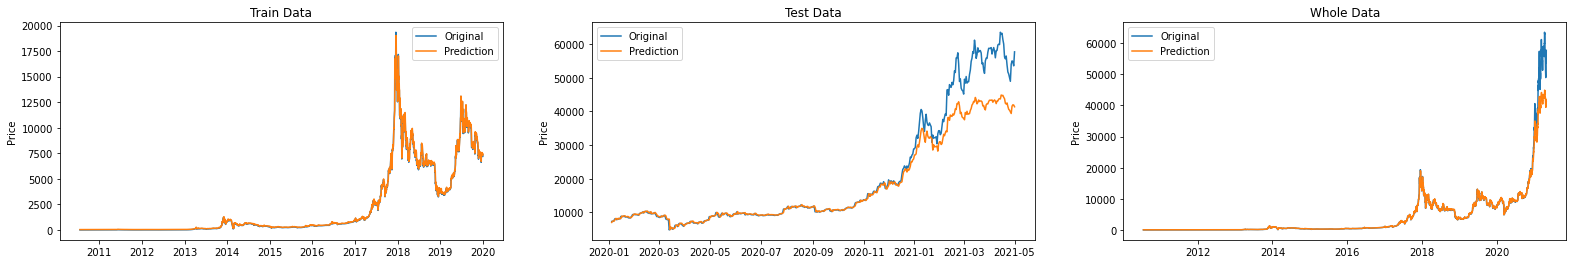

In [ ]:
d_train = bitcoin_df[bitcoin_df['Date']<='2020-01-01'].loc[look_back:len(trainPredict)+look_back,'Date']
d_test = bitcoin_df[bitcoin_df['Date']>='2020-01-02'].loc[len(trainPredict)+(look_back*2)+1:len(bitcoin_df['Price'].values.reshape(-1,1))-1, 'Date']

_, ax = plt.subplots(1,3, figsize=(27, 4))
ax[0].plot(d_train[1:], trainY[0], label = 'Original')
ax[0].plot(d_train[1:], trainPredict, label = 'Prediction')
ax[0].legend()
ax[0].set_ylabel('Price')
ax[0].set_title('Train Data')


ax[1].plot(d_test[1:], testY[0], label = 'Original')
ax[1].plot(d_test[1:], testPredict, label = 'Prediction')
ax[1].legend()
ax[1].set_ylabel('Price')
ax[1].set_title('Test Data')

ax[2].plot(list(d_train[1:])+list(d_test[1:]), list(trainY[0])+list(testY[0]), label = 'Original')
ax[2].plot(list(d_train[1:])+list(d_test[1:]), list(trainPredict)+list(testPredict), label = 'Prediction')
ax[2].legend()
ax[2].set_ylabel('Price')
ax[2].set_title('Whole Data')

**8)Linear Regression**

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
bitcoin_df_scaled = scaler.fit_transform(bitcoin_df['Price'].values.reshape(-1,1))

bitcoin_train_df_scaled = bitcoin_df_scaled[bitcoin_df['Date']<='2020-01-01']
bitcoin_test_df_scaled = bitcoin_df_scaled[bitcoin_df['Date']>='2020-01-02']

look_back = 1
# trainX, trainY = create_dataset(bitcoin_train_df['Price'].values.reshape(-1,1), look_back)
# testX, testY = create_dataset(bitcoin_test_df['Price'].values.reshape(-1,1), look_back)

trainX, trainY = create_dataset(bitcoin_train_df_scaled, look_back)
testX, testY = create_dataset(bitcoin_test_df_scaled, look_back)

# reshape input to be [samples, features]
trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1]))

In [ ]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression().fit(trainX, trainY)
y_prediction_train_lr = model_lr.predict(trainX)
y_prediction_test_lr = model_lr.predict(testX)

# invert predictions
y_prediction_train_lr = scaler.inverse_transform(y_prediction_train_lr.reshape(-1,1))
trainY = scaler.inverse_transform([trainY])
y_prediction_test_lr = scaler.inverse_transform(y_prediction_test_lr.reshape(-1,1))
testY = scaler.inverse_transform([testY])

trainY = trainY[0]
testY = testY[0]

In [ ]:
# calculate root mean squared error
train_rmse = mean_squared_error(trainY, y_prediction_train_lr, squared=False)
test_rmse = mean_squared_error(testY, y_prediction_test_lr, squared=False)
print('train error: {}, test error: {}'.format(train_rmse, test_rmse))


train_acc = accuracy_reg(trainY, y_prediction_train_lr, error_bound=0.05)
test_acc = accuracy_reg(testY, y_prediction_test_lr, error_bound=0.05)
print('train accuracy 5%: {}, test accuracy 5%: {}'.format(train_acc, test_acc))

train error: 204.49128512488338, test error: 1088.7592811272946
2029 3453 3453
409 484 484
train accuracy 5%: 58.76049811757892, test accuracy 5%: 84.50413223140497


Text(0.5, 1.0, 'Whole Data')

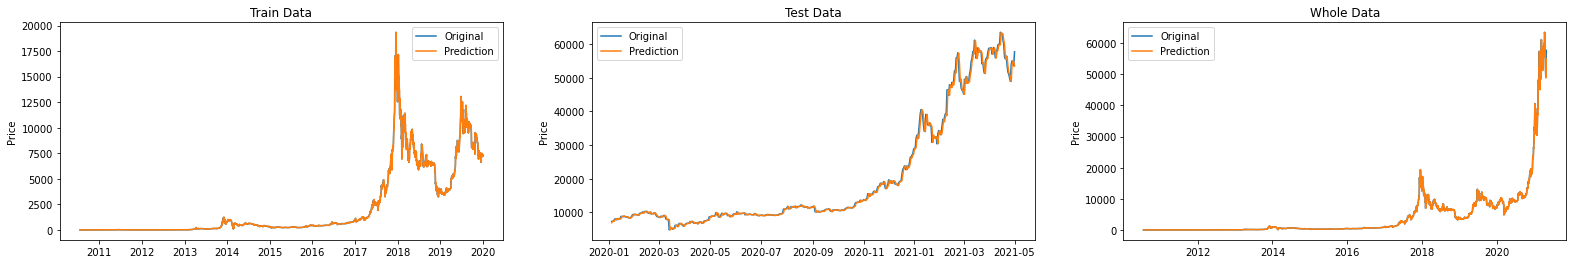

In [ ]:
d_train = bitcoin_df[bitcoin_df['Date']<='2020-01-01'].loc[look_back:len(y_prediction_train_lr)+look_back,'Date']
d_test = bitcoin_df[bitcoin_df['Date']>='2020-01-02'].loc[len(y_prediction_train_lr)+(look_back*2)+1:len(bitcoin_df['Price'].values.reshape(-1,1))-1, 'Date']

_, ax = plt.subplots(1,3, figsize=(27, 4))
ax[0].plot(d_train[1:], trainY, label = 'Original')
ax[0].plot(d_train[1:], y_prediction_train_lr, label = 'Prediction')
ax[0].legend()
ax[0].set_ylabel('Price')
ax[0].set_title('Train Data')


ax[1].plot(d_test[1:], testY, label = 'Original')
ax[1].plot(d_test[1:], y_prediction_test_lr, label = 'Prediction')
ax[1].legend()
ax[1].set_ylabel('Price')
ax[1].set_title('Test Data')

ax[2].plot(list(d_train[1:])+list(d_test[1:]), list(trainY)+list(testY), label = 'Original')
ax[2].plot(list(d_train[1:])+list(d_test[1:]), list(y_prediction_train_lr)+list(y_prediction_test_lr), label = 'Prediction')
ax[2].legend()
ax[2].set_ylabel('Price')
ax[2].set_title('Whole Data')

**9)Ridge Linear Regression**
With one day of look back. So input is price at timestamps t-1, t and the output is predicted price at timestamp t+1

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
bitcoin_df_scaled = scaler.fit_transform(bitcoin_df['Price'].values.reshape(-1,1))

bitcoin_train_df_scaled = bitcoin_df_scaled[bitcoin_df['Date']<='2020-01-01']
bitcoin_test_df_scaled = bitcoin_df_scaled[bitcoin_df['Date']>='2020-01-02']

look_back = 1
trainX, trainY = create_dataset(bitcoin_train_df_scaled, look_back)
testX, testY = create_dataset(bitcoin_test_df_scaled, look_back)

# reshape input to be [samples, features]
trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1]))

In [ ]:
from sklearn import linear_model

model_ridge = linear_model.Ridge(alpha=0.1).fit(trainX, trainY)
y_prediction_train_ridge = model_ridge.predict(trainX)
y_prediction_test_ridge = model_ridge.predict(testX)

# invert predictions
y_prediction_train_ridge = scaler.inverse_transform(y_prediction_train_ridge.reshape(-1,1))
trainY = scaler.inverse_transform([trainY])
y_prediction_test_ridge = scaler.inverse_transform(y_prediction_test_ridge.reshape(-1,1))
testY = scaler.inverse_transform([testY])

trainY = trainY[0]
testY = testY[0]

In [ ]:
# calculate root mean squared error
train_rmse = mean_squared_error(trainY, y_prediction_train_ridge, squared=False)
test_rmse = mean_squared_error(testY, y_prediction_test_ridge, squared=False)
print('train error: {}, test error: {}'.format(train_rmse, test_rmse))


train_acc = accuracy_reg(trainY, y_prediction_train_ridge, error_bound=0.05)
test_acc = accuracy_reg(testY, y_prediction_test_ridge, error_bound=0.05)
print('train accuracy 5%: {}, test accuracy 5%: {}'.format(train_acc, test_acc))

train error: 207.22415607055342, test error: 1145.212748167857
1461 3453 3453
400 484 484
train accuracy 5%: 42.3110338835795, test accuracy 5%: 82.64462809917356


Text(0.5, 1.0, 'Whole Data')

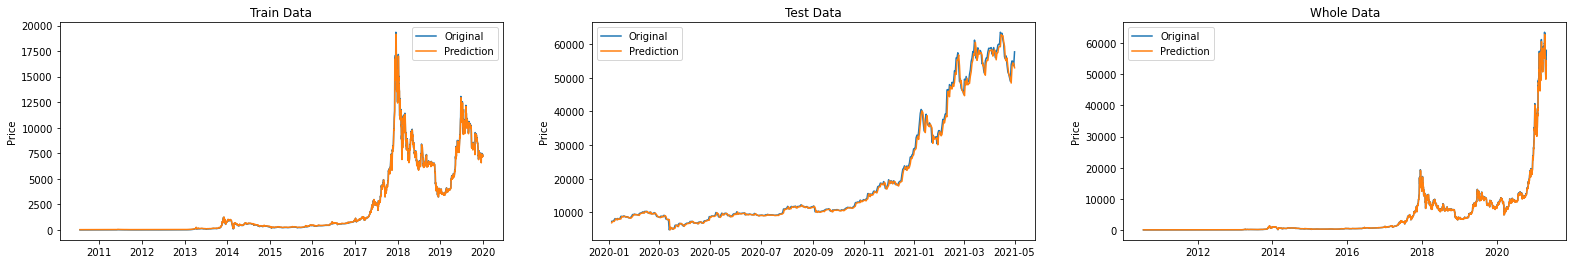

In [ ]:
d_train = bitcoin_df[bitcoin_df['Date']<='2020-01-01'].loc[look_back:len(y_prediction_train_ridge)+look_back,'Date']
d_test = bitcoin_df[bitcoin_df['Date']>='2020-01-02'].loc[len(y_prediction_train_ridge)+(look_back*2)+1:len(bitcoin_df['Price'].values.reshape(-1,1))-1, 'Date']

_, ax = plt.subplots(1,3, figsize=(27, 4))
ax[0].plot(d_train[1:], trainY, label = 'Original')
ax[0].plot(d_train[1:], y_prediction_train_ridge, label = 'Prediction')
ax[0].legend()
ax[0].set_ylabel('Price')
ax[0].set_title('Train Data')


ax[1].plot(d_test[1:], testY, label = 'Original')
ax[1].plot(d_test[1:], y_prediction_test_ridge, label = 'Prediction')
ax[1].legend()
ax[1].set_ylabel('Price')
ax[1].set_title('Test Data')

ax[2].plot(list(d_train[1:])+list(d_test[1:]), list(trainY)+list(testY), label = 'Original')
ax[2].plot(list(d_train[1:])+list(d_test[1:]), list(y_prediction_train_ridge)+list(y_prediction_test_ridge), label = 'Prediction')
ax[2].legend()
ax[2].set_ylabel('Price')
ax[2].set_title('Whole Data')

**10)Seasonal Autoregressive Integrated Moving-Average (SARIMA)**


*   models the next step in the sequence as a linear function of the differenced observations, errors, differenced seasonal observations, and seasonal errors at prior time steps.
* combines the ARIMA model with the ability to perform the same autoregression, differencing, and moving average modeling at the seasonal level
*   suitable for univariate time series with trend and/or seasonal components.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
# fit model
historical_data = list(bitcoin_train_df['Price'])
y_prediction_test = []
for timestamp in range(len(bitcoin_test_df)):
  sarima = SARIMAX(historical_data, order=(1, 1, 1),  seasonal_order=(0, 0, 0, 0))
  model_sarima = sarima.fit()
  # make prediction

  # for first timestamp, get the prediction for the whole training data and store it
  if timestamp == 0:
    y_prediction_train = model_sarima.predict(0, len(bitcoin_train_df)-1)

  # predict for the timestamp-th instance in test set
  pred = model_sarima.predict(len(bitcoin_train_df)+timestamp, len(bitcoin_train_df)+timestamp)
  y_prediction_test.append(pred)

  # append the real value of timestamp-th isntance to training set and re-train the model
  historical_data.append(bitcoin_test_df['Price'].values[timestamp])
  
  #y_prediction_test = model_ar.predict(len(bitcoin_train_df), len(bitcoin_train_df)+len(bitcoin_test_df)-1)

print(len(y_prediction_train), len(y_prediction_test))

3455 486


In [ ]:
len(bitcoin_train_df['Price'].values), len(y_prediction_train)

(3455, 3455)

train error: 203.92150351047783, test error: 1090.8758581140335
2811 3455 3455
413 486 486
train accuracy 5%: 81.3603473227207, test accuracy 5%: 84.97942386831275


Text(0.5, 1.0, 'Whole Data')

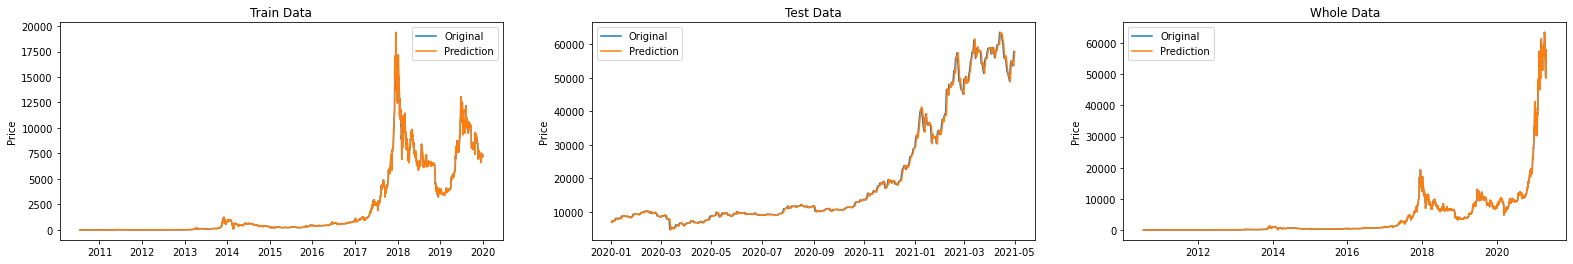

In [ ]:
train_rmse = mean_squared_error(bitcoin_train_df['Price'].values, y_prediction_train, squared=False)
test_rmse = mean_squared_error(bitcoin_test_df['Price'].values, y_prediction_test, squared=False)
print('train error: {}, test error: {}'.format(train_rmse, test_rmse))


train_acc = accuracy_reg(bitcoin_train_df['Price'].values, y_prediction_train, error_bound=0.05)
test_acc = accuracy_reg(bitcoin_test_df['Price'].values, y_prediction_test, error_bound=0.05)
print('train accuracy 5%: {}, test accuracy 5%: {}'.format(train_acc, test_acc))

_, ax = plt.subplots(1,3, figsize=(27, 4))
ax[0].plot(bitcoin_train_df['Date'].values, bitcoin_train_df['Price'].values, label = 'Original')
ax[0].plot(bitcoin_train_df['Date'].values, y_prediction_train, label = 'Prediction')
ax[0].legend()
ax[0].set_ylabel('Price')
ax[0].set_title('Train Data')

ax[1].plot(bitcoin_test_df['Date'], bitcoin_test_df['Price'], label = 'Original')
ax[1].plot(bitcoin_test_df['Date'], y_prediction_test, label = 'Prediction')
ax[1].legend()
ax[1].set_ylabel('Price')
ax[1].set_title('Test Data')

ax[2].plot(bitcoin_df['Date'].values,
           list(bitcoin_train_df['Price'].values)+list(bitcoin_test_df['Price'].values)
          , label = 'Original')
ax[2].plot(bitcoin_df['Date'].values,
           list(y_prediction_train)+list(y_prediction_test)
           , label = 'Prediction')
ax[2].legend()
ax[2].set_ylabel('Price')
ax[2].set_title('Whole Data')

**11)Decision Tree Regression**
With one day of look back. So input is price at timestamps t-1, t and the output is predicted price at timestamp t+1



*   tested with different depths, from 1 to 10, depth = 6 gives the best performance.
* Tested with different values of look_back, got best results with look_back 1



In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
bitcoin_df_scaled = scaler.fit_transform(bitcoin_df['Price'].values.reshape(-1,1))

bitcoin_train_df_scaled = bitcoin_df_scaled[bitcoin_df['Date']<='2020-01-01']
bitcoin_test_df_scaled = bitcoin_df_scaled[bitcoin_df['Date']>='2020-01-02']

look_back = 1
trainX, trainY = create_dataset(bitcoin_train_df_scaled, look_back)
testX, testY = create_dataset(bitcoin_test_df_scaled, look_back)

# reshape input to be [samples, features]
trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1]))

In [ ]:
from sklearn.model_selection import GridSearchCV
model_dt = DecisionTreeRegressor(random_state=0)#.fit(trainX, trainY)

grid_params = {
    'criterion' : ['mse', 'mae'],
    'max_depth' : [3, 5, 7, 10],
    'min_samples_split' : range(2, 10, 1),
    'min_samples_leaf' : range(2, 10, 1)
    }
grid_search = GridSearchCV(model_dt, grid_params, cv = 5, n_jobs = -1, verbose = 1)
grid_search.fit(trainX, trainY)

print('Grid Search best parameters')
print(grid_search.best_params_)
model_dt = grid_search.best_estimator_

print('Decision Tree Results with Best Estimator')
#linear_model.Ridge(alpha=1).fit(trainX, trainY)
y_prediction_train_dt = model_dt.predict(trainX)
y_prediction_test_dt = model_dt.predict(testX)

# invert predictions
y_prediction_train_dt = scaler.inverse_transform(y_prediction_train_dt.reshape(-1,1))
trainY = scaler.inverse_transform([trainY])
y_prediction_test_dt = scaler.inverse_transform(y_prediction_test_dt.reshape(-1,1))
testY = scaler.inverse_transform([testY])

trainY = trainY[0]
testY = testY[0]

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   33.8s


Grid Search best parameters
{'criterion': 'mae', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
Decision Tree Results with Best Estimator


[Parallel(n_jobs=-1)]: Done 2560 out of 2560 | elapsed:   48.4s finished


In [ ]:
# calculate root mean squared error
train_rmse = mean_squared_error(trainY, y_prediction_train_dt, squared=False)
test_rmse = mean_squared_error(testY, y_prediction_test_dt, squared=False)
print('train error: {}, test error: {}'.format(train_rmse, test_rmse))


train_acc = accuracy_reg(trainY, y_prediction_train_dt, error_bound=0.05)
test_acc = accuracy_reg(testY, y_prediction_test_dt, error_bound=0.05)
print('train accuracy 5%: {}, test accuracy 5%: {}'.format(train_acc, test_acc))

train error: 184.98367025087512, test error: 15412.440433727801
2826 3453 3453
284 484 484
train accuracy 5%: 81.84187662901824, test accuracy 5%: 58.67768595041323


Text(0.5, 1.0, 'Whole Data')

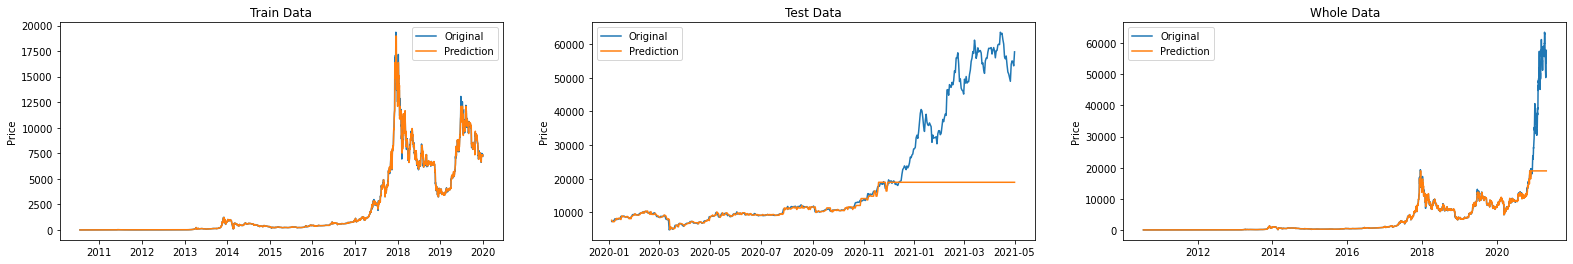

In [ ]:
d_train = bitcoin_df[bitcoin_df['Date']<='2020-01-01'].loc[look_back:len(y_prediction_train_dt)+look_back,'Date']
d_test = bitcoin_df[bitcoin_df['Date']>='2020-01-02'].loc[len(y_prediction_train_dt)+(look_back*2)+1:len(bitcoin_df['Price'].values.reshape(-1,1))-1, 'Date']

_, ax = plt.subplots(1,3, figsize=(27, 4))
ax[0].plot(d_train[1:], trainY, label = 'Original')
ax[0].plot(d_train[1:], y_prediction_train_dt, label = 'Prediction')
ax[0].legend()
ax[0].set_ylabel('Price')
ax[0].set_title('Train Data')


ax[1].plot(d_test[1:], testY, label = 'Original')
ax[1].plot(d_test[1:], y_prediction_test_dt, label = 'Prediction')
ax[1].legend()
ax[1].set_ylabel('Price')
ax[1].set_title('Test Data')

ax[2].plot(list(d_train[1:])+list(d_test[1:]), list(trainY)+list(testY), label = 'Original')
ax[2].plot(list(d_train[1:])+list(d_test[1:]), list(y_prediction_train_dt)+list(y_prediction_test_dt), label = 'Prediction')
ax[2].legend()
ax[2].set_ylabel('Price')
ax[2].set_title('Whole Data')

# **Boosting, Bagging and Voting For Regressors**

**Voting**

In [ ]:
from sklearn.ensemble import VotingRegressor
from sklearn import linear_model

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
bitcoin_df_scaled = scaler.fit_transform(bitcoin_df['Price'].values.reshape(-1,1))

bitcoin_train_df_scaled = bitcoin_df_scaled[bitcoin_df['Date']<='2020-01-01']
bitcoin_test_df_scaled = bitcoin_df_scaled[bitcoin_df['Date']>='2020-01-02']

look_back = 1
trainX, trainY = create_dataset(bitcoin_train_df_scaled, look_back)
testX, testY = create_dataset(bitcoin_test_df_scaled, look_back)

# reshape input to be [samples, features]
trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1]))

In [ ]:
#'criterion': 'mae', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2
reg1 = DecisionTreeRegressor(random_state=0, criterion= 'mae', max_depth=5, min_samples_leaf =5, min_samples_split= 2)
reg2 = DecisionTreeRegressor(random_state=0, criterion= 'mae', max_depth=10, min_samples_leaf =5, min_samples_split= 2)
reg3 = DecisionTreeRegressor(random_state=0, criterion= 'mse', max_depth=10, min_samples_leaf =5, min_samples_split= 2)

reg4 = linear_model.Ridge(alpha=0.1)
reg5 = LinearRegression()

ereg = VotingRegressor(estimators=[('dt_mae_5', reg1), ('dt_mae_10', reg2), ('dt_mse+10', reg3), ('lr_ridge', reg4), ('lr', reg5)])
ereg = ereg.fit(trainX, trainY)

y_prediction_train_ens = ereg.predict(trainX)
y_prediction_test_ens = ereg.predict(testX)

# invert predictions
y_prediction_train_ens = scaler.inverse_transform(y_prediction_train_ens.reshape(-1,1))
trainY = scaler.inverse_transform([trainY])
y_prediction_test_ens = scaler.inverse_transform(y_prediction_test_ens.reshape(-1,1))
testY = scaler.inverse_transform([testY])

trainY = trainY[0]
testY = testY[0]

# calculate root mean squared error
train_rmse = mean_squared_error(trainY, y_prediction_train_ens, squared=False)
test_rmse = mean_squared_error(testY, y_prediction_test_ens, squared=False)
print('train error: {}, test error: {}'.format(train_rmse, test_rmse))


train_acc = accuracy_reg(trainY, y_prediction_train_ens, error_bound=0.05)
test_acc = accuracy_reg(testY, y_prediction_test_ens, error_bound=0.05)
print('train accuracy 5%: {}, test accuracy 5%: {}'.format(train_acc, test_acc))

train error: 185.96497160937074, test error: 9440.73212461816
1947 3453 3453
297 484 484
train accuracy 5%: 56.385751520417024, test accuracy 5%: 61.36363636363637


Text(0.5, 1.0, 'Whole Data')

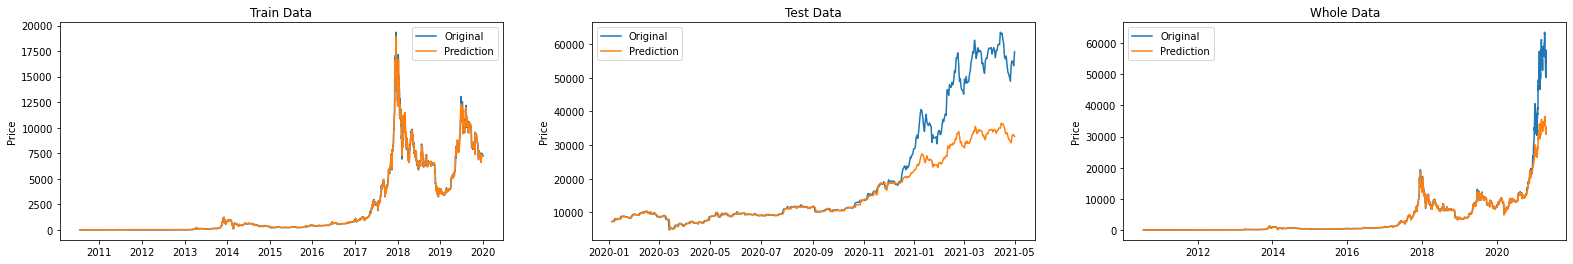

In [ ]:
d_train = bitcoin_df[bitcoin_df['Date']<='2020-01-01'].loc[look_back:len(y_prediction_train_ens)+look_back,'Date']
d_test = bitcoin_df[bitcoin_df['Date']>='2020-01-02'].loc[len(y_prediction_train_ens)+(look_back*2)+1:len(bitcoin_df['Price'].values.reshape(-1,1))-1, 'Date']

_, ax = plt.subplots(1,3, figsize=(27, 4))
ax[0].plot(d_train[1:], trainY, label = 'Original')
ax[0].plot(d_train[1:], y_prediction_train_ens, label = 'Prediction')
ax[0].legend()
ax[0].set_ylabel('Price')
ax[0].set_title('Train Data')


ax[1].plot(d_test[1:], testY, label = 'Original')
ax[1].plot(d_test[1:], y_prediction_test_ens, label = 'Prediction')
ax[1].legend()
ax[1].set_ylabel('Price')
ax[1].set_title('Test Data')

ax[2].plot(list(d_train[1:])+list(d_test[1:]), list(trainY)+list(testY), label = 'Original')
ax[2].plot(list(d_train[1:])+list(d_test[1:]), list(y_prediction_train_ens)+list(y_prediction_test_ens), label = 'Prediction')
ax[2].legend()
ax[2].set_ylabel('Price')
ax[2].set_title('Whole Data')

**Bagging**

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR

scaler = MinMaxScaler(feature_range=(0, 1))
bitcoin_df_scaled = scaler.fit_transform(bitcoin_df['Price'].values.reshape(-1,1))

bitcoin_train_df_scaled = bitcoin_df_scaled[bitcoin_df['Date']<='2020-01-01']
bitcoin_test_df_scaled = bitcoin_df_scaled[bitcoin_df['Date']>='2020-01-02']

look_back = 1
trainX, trainY = create_dataset(bitcoin_train_df_scaled, look_back)
testX, testY = create_dataset(bitcoin_test_df_scaled, look_back)

# reshape input to be [samples, features]
trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1]))

bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(),
                           n_estimators=50, random_state=0)
bagging_model = bagging.fit(trainX, trainY)

y_prediction_train_bag = bagging_model.predict(trainX)
y_prediction_test_bag = bagging_model.predict(testX)


# invert predictions
y_prediction_train_bag = scaler.inverse_transform(y_prediction_train_bag.reshape(-1,1))
trainY = scaler.inverse_transform([trainY])
y_prediction_test_bag = scaler.inverse_transform(y_prediction_test_bag.reshape(-1,1))
testY = scaler.inverse_transform([testY])

trainY = trainY[0]
testY = testY[0]

In [ ]:
# calculate root mean squared error
train_rmse = mean_squared_error(trainY, y_prediction_train_bag, squared=False)
test_rmse = mean_squared_error(testY, y_prediction_test_bag, squared=False)
print('train error: {}, test error: {}'.format(train_rmse, test_rmse))


train_acc = accuracy_reg(trainY, y_prediction_train_bag, error_bound=0.05)
test_acc = accuracy_reg(testY, y_prediction_test_bag, error_bound=0.05)
print('train accuracy 5%: {}, test accuracy 5%: {}'.format(train_acc, test_acc))

train error: 96.44827605908856, test error: 15508.654800969683
2177 3453 3453
252 484 484
train accuracy 5%: 63.046626122212565, test accuracy 5%: 52.066115702479344


Text(0.5, 1.0, 'Whole Data')

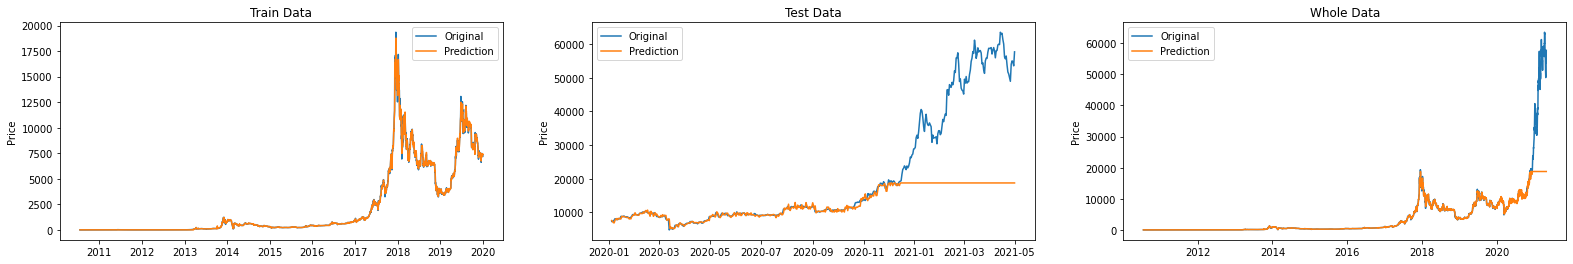

In [ ]:
d_train = bitcoin_df[bitcoin_df['Date']<='2020-01-01'].loc[look_back:len(y_prediction_train_bag)+look_back,'Date']
d_test = bitcoin_df[bitcoin_df['Date']>='2020-01-02'].loc[len(y_prediction_train_bag)+(look_back*2)+1:len(bitcoin_df['Price'].values.reshape(-1,1))-1, 'Date']

_, ax = plt.subplots(1,3, figsize=(27, 4))
ax[0].plot(d_train[1:], trainY, label = 'Original')
ax[0].plot(d_train[1:], y_prediction_train_bag, label = 'Prediction')
ax[0].legend()
ax[0].set_ylabel('Price')
ax[0].set_title('Train Data')


ax[1].plot(d_test[1:], testY, label = 'Original')
ax[1].plot(d_test[1:], y_prediction_test_bag, label = 'Prediction')
ax[1].legend()
ax[1].set_ylabel('Price')
ax[1].set_title('Test Data')

ax[2].plot(list(d_train[1:])+list(d_test[1:]), list(trainY)+list(testY), label = 'Original')
ax[2].plot(list(d_train[1:])+list(d_test[1:]), list(y_prediction_train_bag)+list(y_prediction_test_bag), label = 'Prediction')
ax[2].legend()
ax[2].set_ylabel('Price')
ax[2].set_title('Whole Data')

**Boosting**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

scaler = MinMaxScaler(feature_range=(0, 1))
bitcoin_df_scaled = scaler.fit_transform(bitcoin_df['Price'].values.reshape(-1,1))

bitcoin_train_df_scaled = bitcoin_df_scaled[bitcoin_df['Date']<='2020-01-01']
bitcoin_test_df_scaled = bitcoin_df_scaled[bitcoin_df['Date']>='2020-01-02']

look_back = 1
trainX, trainY = create_dataset(bitcoin_train_df_scaled, look_back)
testX, testY = create_dataset(bitcoin_test_df_scaled, look_back)

# reshape input to be [samples, features]
trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1]))

boosting = GradientBoostingRegressor(random_state=0, n_estimators= 100, criterion = 'mae')
boosting_model = boosting.fit(trainX, trainY)

y_prediction_train_boost = boosting_model.predict(trainX)
y_prediction_test_boost = boosting_model.predict(testX)


# invert predictions
y_prediction_train_boost = scaler.inverse_transform(y_prediction_train_boost.reshape(-1,1))
trainY = scaler.inverse_transform([trainY])
y_prediction_test_boost = scaler.inverse_transform(y_prediction_test_boost.reshape(-1,1))
testY = scaler.inverse_transform([testY])

trainY = trainY[0]
testY = testY[0]

In [ ]:
# calculate root mean squared error
train_rmse = mean_squared_error(trainY, y_prediction_train_boost, squared=False)
test_rmse = mean_squared_error(testY, y_prediction_test_boost, squared=False)
print('train error: {}, test error: {}'.format(train_rmse, test_rmse))


train_acc = accuracy_reg(trainY, y_prediction_train_boost, error_bound=0.05)
test_acc = accuracy_reg(testY, y_prediction_test_boost, error_bound=0.05)
print('train accuracy 5%: {}, test accuracy 5%: {}'.format(train_acc, test_acc))

train error: 171.35724745352337, test error: 15376.594234692775
2501 3453 3453
290 484 484
train accuracy 5%: 72.42977121343759, test accuracy 5%: 59.917355371900825


Text(0.5, 1.0, 'Whole Data')

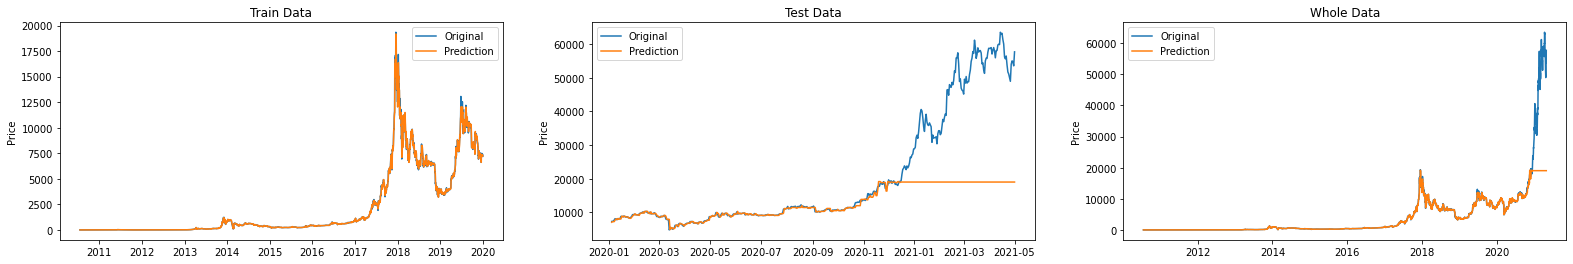

In [ ]:
d_train = bitcoin_df[bitcoin_df['Date']<='2020-01-01'].loc[look_back:len(y_prediction_train_boost)+look_back,'Date']
d_test = bitcoin_df[bitcoin_df['Date']>='2020-01-02'].loc[len(y_prediction_train_boost)+(look_back*2)+1:len(bitcoin_df['Price'].values.reshape(-1,1))-1, 'Date']

_, ax = plt.subplots(1,3, figsize=(27, 4))
ax[0].plot(d_train[1:], trainY, label = 'Original')
ax[0].plot(d_train[1:], y_prediction_train_boost, label = 'Prediction')
ax[0].legend()
ax[0].set_ylabel('Price')
ax[0].set_title('Train Data')


ax[1].plot(d_test[1:], testY, label = 'Original')
ax[1].plot(d_test[1:], y_prediction_test_boost, label = 'Prediction')
ax[1].legend()
ax[1].set_ylabel('Price')
ax[1].set_title('Test Data')

ax[2].plot(list(d_train[1:])+list(d_test[1:]), list(trainY)+list(testY), label = 'Original')
ax[2].plot(list(d_train[1:])+list(d_test[1:]), list(y_prediction_train_boost)+list(y_prediction_test_boost), label = 'Prediction')
ax[2].legend()
ax[2].set_ylabel('Price')
ax[2].set_title('Whole Data')

# **AdaBoost**

In [ ]:
from sklearn.ensemble import AdaBoostRegressor



scaler = MinMaxScaler(feature_range=(0, 1))
bitcoin_df_scaled = scaler.fit_transform(bitcoin_df['Price'].values.reshape(-1,1))

bitcoin_train_df_scaled = bitcoin_df_scaled[bitcoin_df['Date']<='2020-01-01']
bitcoin_test_df_scaled = bitcoin_df_scaled[bitcoin_df['Date']>='2020-01-02']


look_back = 1
trainX, trainY = create_dataset(bitcoin_train_df_scaled, look_back)
testX, testY = create_dataset(bitcoin_test_df_scaled, look_back)

# reshape input to be [samples, features]
trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1]))

adaboost = AdaBoostRegressor()

grid_params = {
    'n_estimators' : [10, 40, 80, 100],
    'learning_rate' : [0.01, 0.1, 1],
    'loss': ['linear', 'square'],
    'random_state' : [0],
    'base_estimator': [DecisionTreeRegressor(criterion= 'mae', max_depth=10, min_samples_leaf =5, min_samples_split= 2), ]
    }
grid_search = GridSearchCV(adaboost, grid_params, cv = 5, n_jobs = -1, verbose = 1)
grid_search.fit(trainX, trainY)

print('Grid Search best parameters')
print(grid_search.best_params_)
adaboost_model = grid_search.best_estimator_

print('AdaBoost Results with Best Estimator')
#linear_model.Ridge(alpha=1).fit(trainX, trainY)
y_prediction_train_ada = adaboost_model.predict(trainX)
y_prediction_test_ada = adaboost_model.predict(testX)


# invert predictions
y_prediction_train_ada = scaler.inverse_transform(y_prediction_train_ada.reshape(-1,1))
trainY = scaler.inverse_transform([trainY])
y_prediction_test_ada = scaler.inverse_transform(y_prediction_test_ada.reshape(-1,1))
testY = scaler.inverse_transform([testY])

trainY = trainY[0]
testY = testY[0]


# calculate root mean squared error
train_rmse = mean_squared_error(trainY, y_prediction_train_ada, squared=False)
test_rmse = mean_squared_error(testY, y_prediction_test_ada, squared=False)
print('train error: {}, test error: {}'.format(train_rmse, test_rmse))


train_acc = accuracy_reg(trainY, y_prediction_train_ada, error_bound=0.05)
test_acc = accuracy_reg(testY, y_prediction_test_ada, error_bound=0.05)
print('train accuracy 5%: {}, test accuracy 5%: {}'.format(train_acc, test_acc))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  4.0min finished


Grid Search best parameters
{'base_estimator': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best'), 'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 80, 'random_state': 0}
AdaBoost Results with Best Estimator
train error: 163.13972913464605, test error: 15389.877389562414
2874 3453 3453
294 484 484
train accuracy 5%: 83.23197219808863, test accuracy 5%: 60.74380165289256


In [ ]:
allscores=grid_search.cv_results_
cols = ['mean_test_score', 'param_loss', 'param_n_estimators', 'param_learning_rate']
allscores_smaller = { k: allscores[k] for k in cols }

allscores_df = pd.DataFrame.from_dict(allscores_smaller)
allscores_df.head(25)

,mean_test_score,param_loss,param_n_estimators,param_learning_rate
0,0.849759,linear,10,0.01
1,0.848306,linear,40,0.01
2,0.850270,linear,80,0.01
3,0.849723,linear,100,0.01
4,0.850107,square,10,0.01
5,0.850159,square,40,0.01
6,0.851057,square,80,0.01
7,0.851016,square,100,0.01
8,0.847570,linear,10,0.1
9,0.833040,linear,40,0.1


Text(0.5, 1.0, 'Whole Data')

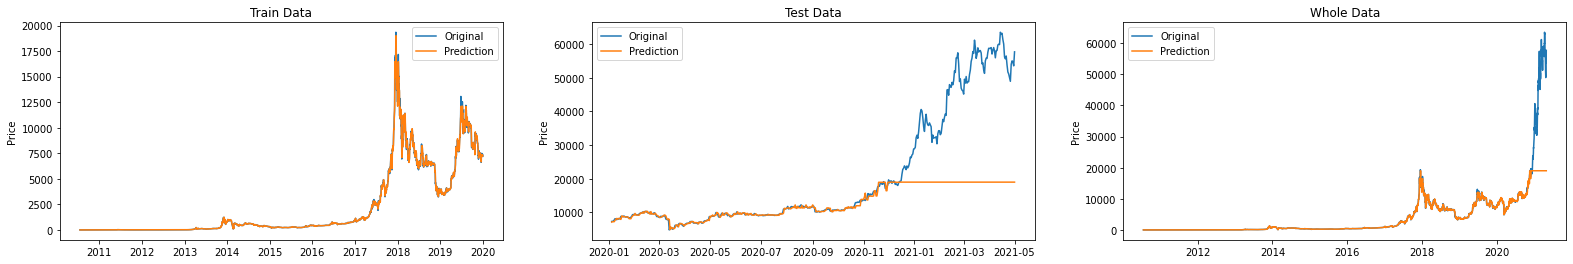

In [ ]:
d_train = bitcoin_df[bitcoin_df['Date']<='2020-01-01'].loc[look_back:len(y_prediction_train_ada)+look_back,'Date']
d_test = bitcoin_df[bitcoin_df['Date']>='2020-01-02'].loc[len(y_prediction_train_ada)+(look_back*2)+1:len(bitcoin_df['Price'].values.reshape(-1,1))-1, 'Date']

_, ax = plt.subplots(1,3, figsize=(27, 4))
ax[0].plot(d_train[1:], trainY, label = 'Original')
ax[0].plot(d_train[1:], y_prediction_train_ada, label = 'Prediction')
ax[0].legend()
ax[0].set_ylabel('Price')
ax[0].set_title('Train Data')


ax[1].plot(d_test[1:], testY, label = 'Original')
ax[1].plot(d_test[1:], y_prediction_test_ada, label = 'Prediction')
ax[1].legend()
ax[1].set_ylabel('Price')
ax[1].set_title('Test Data')

ax[2].plot(list(d_train[1:])+list(d_test[1:]), list(trainY)+list(testY), label = 'Original')
ax[2].plot(list(d_train[1:])+list(d_test[1:]), list(y_prediction_train_ada)+list(y_prediction_test_ada), label = 'Prediction')
ax[2].legend()
ax[2].set_ylabel('Price')
ax[2].set_title('Whole Data')

# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

scaler = MinMaxScaler(feature_range=(0, 1))
bitcoin_df_scaled = scaler.fit_transform(bitcoin_df['Price'].values.reshape(-1,1))

bitcoin_train_df_scaled = bitcoin_df_scaled[bitcoin_df['Date']<='2020-01-01']
bitcoin_test_df_scaled = bitcoin_df_scaled[bitcoin_df['Date']>='2020-01-02']


look_back = 1
trainX, trainY = create_dataset(bitcoin_train_df_scaled, look_back)
testX, testY = create_dataset(bitcoin_test_df_scaled, look_back)

# reshape input to be [samples, features]
trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1]))

randomforest = RandomForestRegressor()

grid_params = {
    'criterion' : ['mse', 'mae'],
    'max_depth' : [3, 5, 7, 10],
    'min_samples_split' : range(2, 10, 2),
    'min_samples_leaf' : range(2, 10, 2)
    }
grid_search = GridSearchCV(randomforest, grid_params, cv = 5, n_jobs = -1, verbose = 1)
grid_search.fit(trainX, trainY)

print('Grid Search best parameters')
print(grid_search.best_params_)
randomforest_model = grid_search.best_estimator_

print('Random Forest Results with Best Estimator')
#linear_model.Ridge(alpha=1).fit(trainX, trainY)
y_prediction_train_rf = randomforest_model.predict(trainX)
y_prediction_test_rf = randomforest_model.predict(testX)


# invert predictions
y_prediction_train_rf = scaler.inverse_transform(y_prediction_train_rf.reshape(-1,1))
trainY = scaler.inverse_transform([trainY])
y_prediction_test_rf = scaler.inverse_transform(y_prediction_test_rf.reshape(-1,1))
testY = scaler.inverse_transform([testY])

trainY = trainY[0]
testY = testY[0]


# calculate root mean squared error
train_rmse = mean_squared_error(trainY, y_prediction_train_rf, squared=False)
test_rmse = mean_squared_error(testY, y_prediction_test_rf, squared=False)
print('train error: {}, test error: {}'.format(train_rmse, test_rmse))


train_acc = accuracy_reg(trainY, y_prediction_train_rf, error_bound=0.05)
test_acc = accuracy_reg(testY, y_prediction_test_rf, error_bound=0.05)
print('train accuracy 5%: {}, test accuracy 5%: {}'.format(train_acc, test_acc))

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  9.6min finished


Grid Search best parameters
{'criterion': 'mae', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 6}
Random Forest Results with Best Estimator
train error: 162.52432129318845, test error: 15663.870053356814
2918 3453 3453
284 484 484
train accuracy 5%: 84.50622646973646, test accuracy 5%: 58.67768595041323


In [ ]:
allscores=grid_search.cv_results_
cols = ['mean_test_score', 'param_criterion', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf']
allscores_smaller = { k: allscores[k] for k in cols }

allscores_df = pd.DataFrame.from_dict(allscores_smaller)
allscores_df.head(25)

,mean_test_score,param_criterion,param_max_depth,param_min_samples_split,param_min_samples_leaf
0,-448.097142,mse,3,2,2
1,-450.255570,mse,3,4,2
2,-448.973224,mse,3,6,2
3,-448.536742,mse,3,8,2
4,-448.357140,mse,3,2,4
5,-450.663251,mse,3,4,4
6,-448.455088,mse,3,6,4
7,-446.974320,mse,3,8,4
8,-446.265050,mse,3,2,6
9,-448.324854,mse,3,4,6


Text(0.5, 1.0, 'Whole Data')

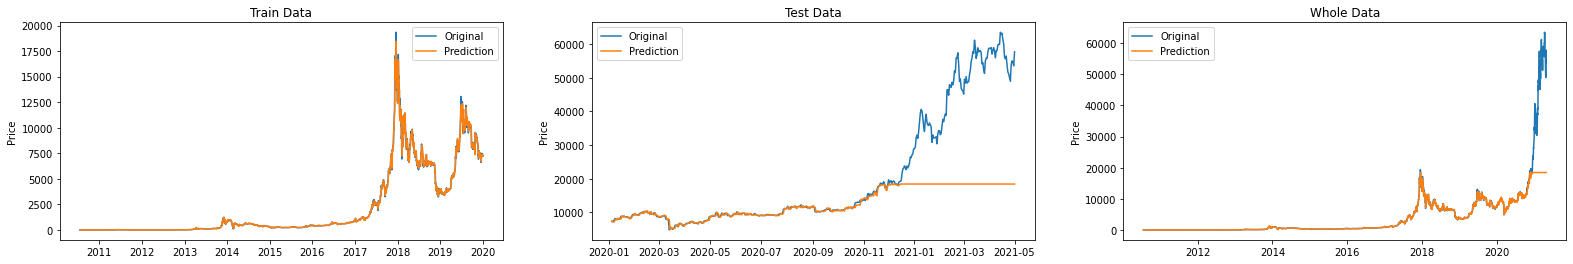

In [ ]:
d_train = bitcoin_df[bitcoin_df['Date']<='2020-01-01'].loc[look_back:len(y_prediction_train_rf)+look_back,'Date']
d_test = bitcoin_df[bitcoin_df['Date']>='2020-01-02'].loc[len(y_prediction_train_rf)+(look_back*2)+1:len(bitcoin_df['Price'].values.reshape(-1,1))-1, 'Date']

_, ax = plt.subplots(1,3, figsize=(27, 4))
ax[0].plot(d_train[1:], trainY, label = 'Original')
ax[0].plot(d_train[1:], y_prediction_train_rf, label = 'Prediction')
ax[0].legend()
ax[0].set_ylabel('Price')
ax[0].set_title('Train Data')


ax[1].plot(d_test[1:], testY, label = 'Original')
ax[1].plot(d_test[1:], y_prediction_test_rf, label = 'Prediction')
ax[1].legend()
ax[1].set_ylabel('Price')
ax[1].set_title('Test Data')

ax[2].plot(list(d_train[1:])+list(d_test[1:]), list(trainY)+list(testY), label = 'Original')
ax[2].plot(list(d_train[1:])+list(d_test[1:]), list(y_prediction_train_rf)+list(y_prediction_test_rf), label = 'Prediction')
ax[2].legend()
ax[2].set_ylabel('Price')
ax[2].set_title('Whole Data')